## Setup

In [1]:
from os import path
import pandas as pd
import numpy as np
import re

from Bio.KEGG import REST
from tqdm.notebook import tqdm
from pymodulon.core import IcaData
from pymodulon.util import explained_variance
from pymodulon.compare import *
from pymodulon.io import *
from pymodulon.plotting import *

In [2]:
# Enter the location of your data here
data_dir = '../data/'

In [3]:
# Load in metadata & TRN files
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_trn = pd.read_csv(path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),sep='\t')

# Load in other files to generate IcaData object
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info_curated_Jan_07_2021.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),
                   threshold_method = 'kmeans')

### iModulon Table Setup

In [4]:
# Compute TRN enrichment, save enrichment data into imodulon table, rename long imod name to shorter one
ica_data.compute_regulon_enrichment(11,'XylR',save=True)
ica_data.compute_regulon_enrichment(12,'YtrA',save=True)
ica_data.compute_regulon_enrichment(13,'LysM',save=True)
ica_data.compute_regulon_enrichment(18,'tfb3',save=True)
ica_data.compute_regulon_enrichment(27,'ArnR+ArnR1+ArnA+ArnB',save=True)
ica_data.compute_regulon_enrichment(29,'FadR',save=True)

reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
ica_data.rename_imodulons({'ArnR+ArnR1+ArnA+ArnB':'ArnRAB'})
ica_data.rename_imodulons({'XylR':'central-carbon'})
ica_data.rename_imodulons({'tfb3':'UV-tfb3'})

# Add single_gene_imodulons and them to imodulon table
sg_imods = ica_data.find_single_gene_imodulons(save=True)
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

# Rename 'single_gene_3' to FadR-KO
ica_data.rename_imodulons({'single_gene_3':'FadR-KO'})

# Add E coli orthologs to imodulon table
ecoli_data = load_json_model('../example_data/example.json')
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.25,
                         ortho_file = '../example_data/example_bbh.csv')

ica_data.imodulon_table['ecoli_ortholog'] = np.nan
for ecoli_mod,target_mod,dist in dots:
    try:
        xx = int(target_mod)
    except ValueError:
        xx = target_mod
    finally:
        ica_data.imodulon_table.loc[xx,'ecoli_ortholog'] = ecoli_mod

# Manually add complex orthologs
ica_data.imodulon_table.loc['central-carbon', 'ecoli_ortholog'] = 'GlpR, crp-KO'
ica_data.imodulon_table.loc[23, 'ecoli_ortholog'] = 'CysB, translation'

# Add KEGG enriched iModulons
kegg_imods_dict = {
    25: 'Cobalamin',
    26: '4-HPA',
    39: 'carotenoid',
    4: 'Riboflavin',
    7: 'carbon-fixation',
    9: 'HMG-CoA',
    10: 'Purine',
    17: 'translation-1',
    19: 'Arginine',
    21: 'translation-2',
    23: 'sulfur-assimilation',
    31: 'TCA-BCAA'
}
ica_data.rename_imodulons(kegg_imods_dict)

# Change thresholds for iModulon enrichment as appropriate
ica_data.change_threshold('Cobalamin', 0.07)
ica_data.change_threshold('Purine', 0.08)
ica_data.change_threshold('Arginine', 0.1)
ica_data.change_threshold('sulfur-assimilation', 0.1)

# Add remaining iModulons
ica_data.rename_imodulons({2: 'SoxL2N'})
ica_data.rename_imodulons({34: 'Replication'})
ica_data.rename_imodulons({35: 'translation-related'})
ica_data.rename_imodulons({5: 'niacin-transport'})
ica_data.rename_imodulons({41: 'Thiamin'})
ica_data.rename_imodulons({22: 'unchar-1'})
ica_data.rename_imodulons({33: 'unchar-2'})
ica_data.rename_imodulons({42: 'unchar-3'})
ica_data.rename_imodulons({32: 'UV-related'})
ica_data.rename_imodulons({38: 'Ammonium-Uptake'})
ica_data.rename_imodulons({14: 'Phenylacetate'})
ica_data.rename_imodulons({8: 'Fe-S-lipoylation'})
ica_data.rename_imodulons({3: 'long-chain-fatty-acid'})
ica_data.rename_imodulons({0: 'pseudogene'})
ica_data.rename_imodulons({1: 'heat-stress'})
ica_data.rename_imodulons({6: 'cold-stress'})
ica_data.rename_imodulons({20: 'Hydtanoinase-acetophenone'})
ica_data.rename_imodulons({30: 'SoxLABCD'})
ica_data.rename_imodulons({36: 'Quinolinate'})
ica_data.rename_imodulons({37: 'aromatic-degradation'})
ica_data.rename_imodulons({44: 'Gly-Ser-Thr'})
ica_data.rename_imodulons({'single_gene_4': 'single_gene_3'})
ica_data.rename_imodulons({'single_gene_5': 'single_gene_4'})
ica_data.rename_imodulons({'single_gene_6': 'single_gene_5'})

---

---

# Literature Validation iModulons

These iModulons recapitulate the known TRN in literature

## iModulon 27: Archaellum iModulon (ArnRAB)

<AxesSubplot:xlabel='Gene Start', ylabel='ArnRAB Gene Weight'>

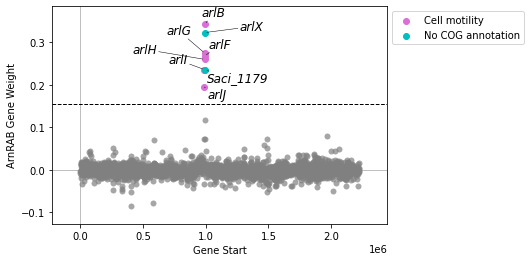

In [5]:
# Gene Weights Plot
# x-axis is gene start location
# y-axis is gene weighting for this specific iModulon
# Only genes with a statistically significant weighting are considered enriched genes of the iModulon

plot_gene_weights(ica_data, 'ArnRAB')

<AxesSubplot:ylabel='ArnRAB iModulon\nActivity'>

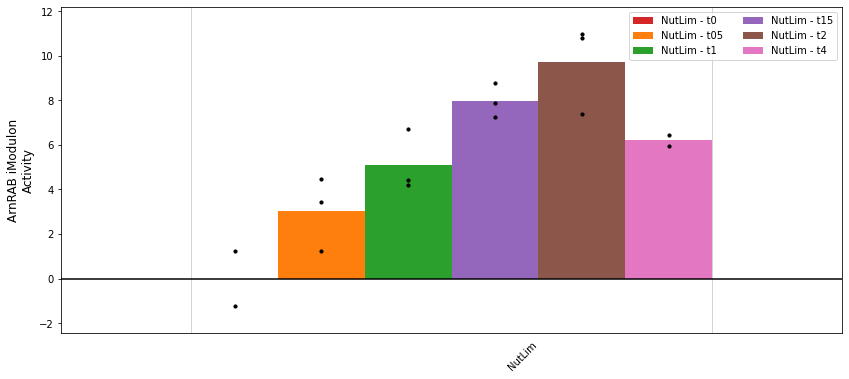

In [6]:
# iModulon Activity Plot
# This shows the activity of the iModulon's genes for various conditions
# In this case, the activity of the iModulon is rising over time under
# nutrient-limiting conditions

# Note that the bars represent the average, which the points represent
# individual samples (2 or 3 for most cases), which represent the technical
# replicates these data come from

fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'ArnRAB', projects='NutLim', highlight='NutLim', ax=ax)

# Note: t0 = 0 min, t05 = 5 min, t1 = 1 hr, t15 = 1.5 hr, t2 = 2 hrs, t4 = 4 hrs

## iModulon 29: FadR iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='FadR Gene Weight'>

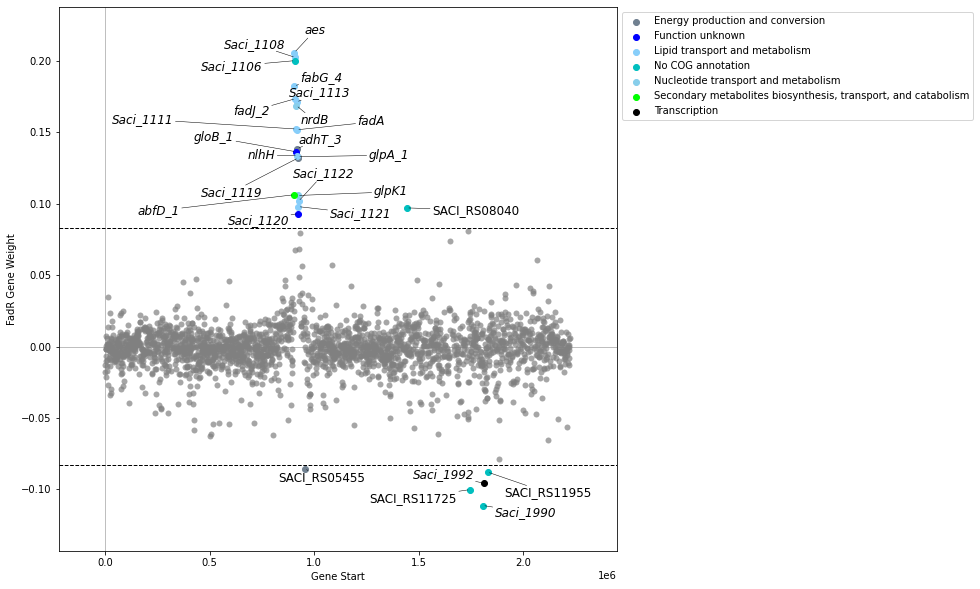

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_gene_weights(ica_data, 'FadR', show_labels=True, ax=ax)

# Enriched cluster in the middle consists of Saci_1103 - Saci_1123
# (excluding Saci_1107, which codes for FadR itself)
# Often, the regulator of an iModulon will not be enriched in the iModulon itself,
# especially if the regulator is itself regulated by a larger network / global regulator

<AxesSubplot:ylabel='FadR iModulon\nActivity'>

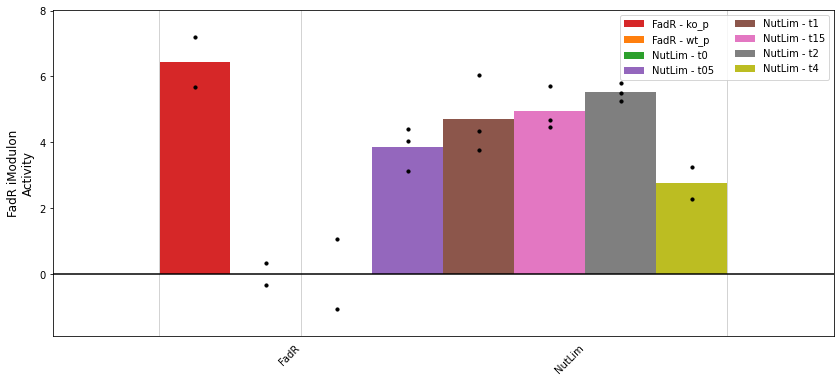

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'FadR', projects=['FadR', 'NutLim'], highlight=['Chrom', 'FadR', 'NutLim'], ax=ax)

## iModulon 24: FadR-KO iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='FadR-KO Gene Weight'>

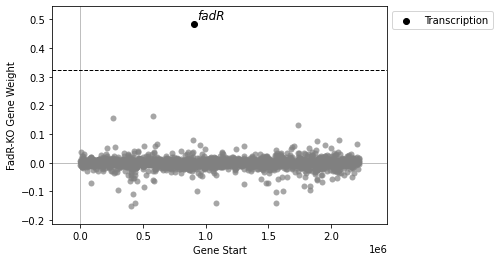

In [9]:
plot_gene_weights(ica_data, 'FadR-KO')

<AxesSubplot:ylabel='FadR-KO iModulon\nActivity'>

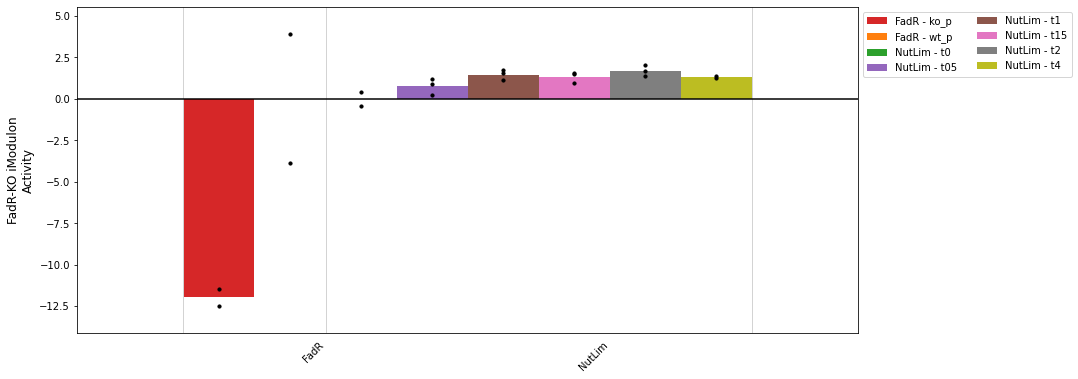

In [10]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'FadR-KO', projects=['FadR', 'NutLim'], highlight=['FadR', 'NutLim'], ax=ax)

---

# Regulon-Matching iModulons

These iModulons match regulons/functions found in literature

## iModulon 11: Central Carbon Metabolism

### Glycerol Uptake, XylR-based Pentose Uptake, SoxM)

<AxesSubplot:xlabel='Gene Start', ylabel='central-carbon Gene Weight'>

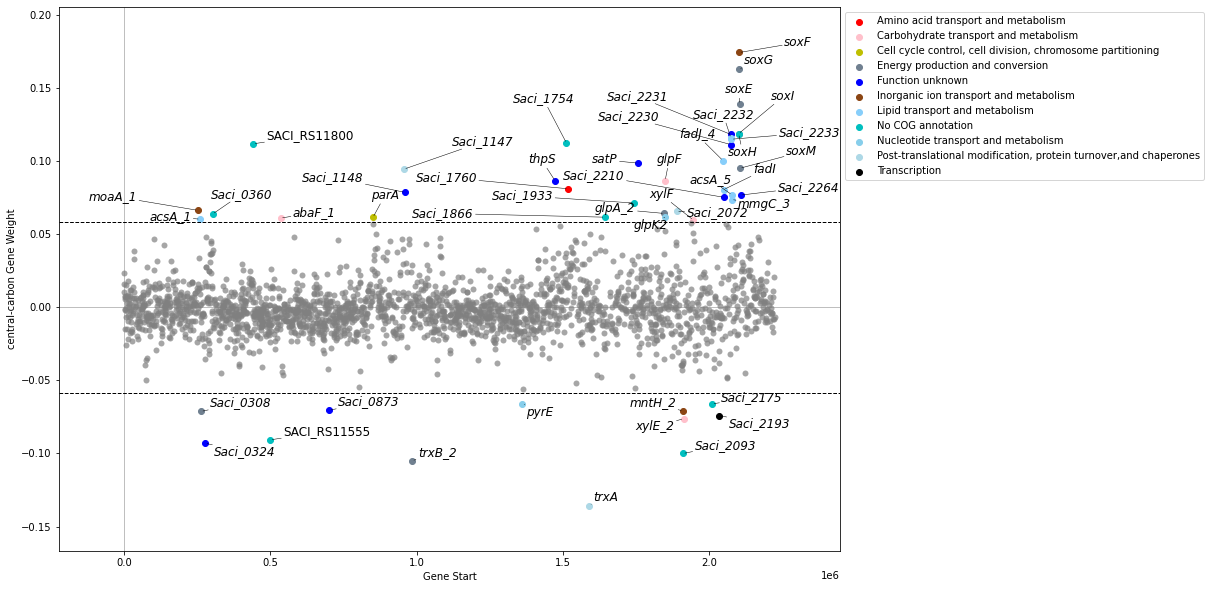

In [11]:
fig, ax = plt.subplots(figsize=(14, 10))

plot_gene_weights(ica_data, 'central-carbon', show_labels=True, ax=ax)

<AxesSubplot:ylabel='central-carbon iModulon\nActivity'>

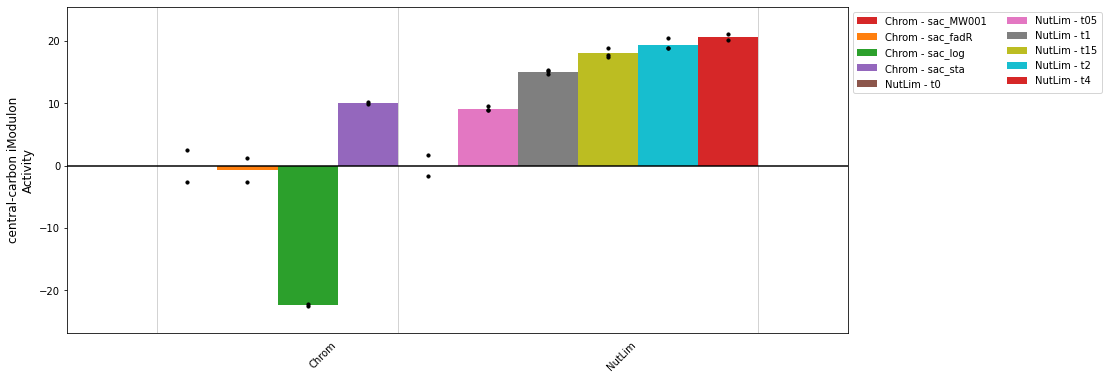

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'central-carbon',
                projects=['Chrom', 'NutLim'],
                highlight=['Chrom', 'NutLim'],
                ax=ax)

## iModulon 12: YtrA iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='YtrA Gene Weight'>

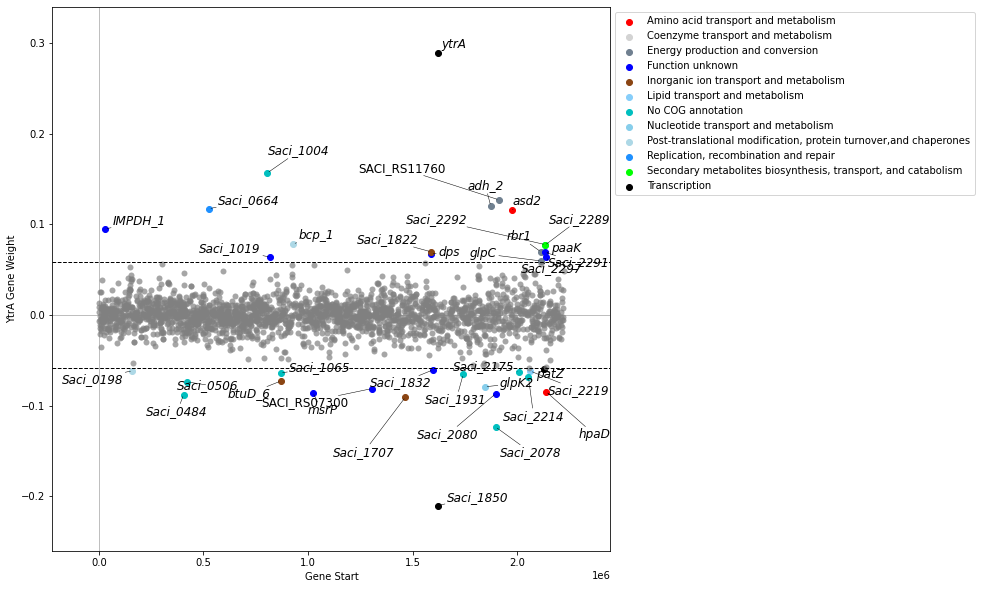

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_gene_weights(ica_data, 'YtrA', show_labels=True, ax=ax)

<AxesSubplot:ylabel='YtrA iModulon\nActivity'>

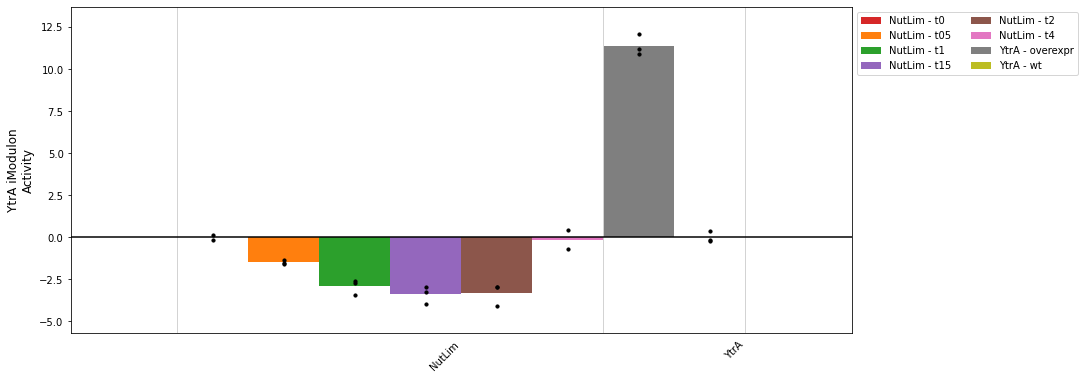

In [14]:
# Unsurprisingly, this iModulon has a high activity in the YtrA overexpression condition

fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'YtrA',
                projects=['NutLim', 'YtrA'],
                highlight=['NutLim', 'YtrA'],
                ax=ax)

## iModulon 13: LysM iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='LysM Gene Weight'>

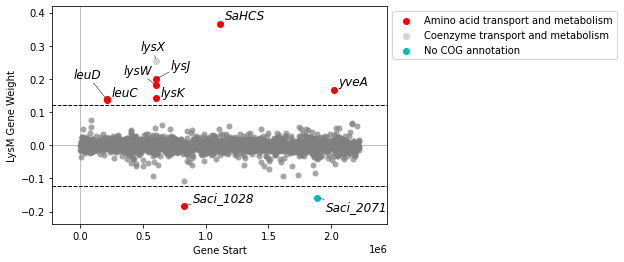

In [15]:
# LysY, LysZ, and LysM are not in this iModulon
# This is because all 3 are expressed polycistronically
# and LysM does not appear as it is the regulator for this iModulon

plot_gene_weights(ica_data, 'LysM')

<AxesSubplot:ylabel='LysM iModulon\nActivity'>

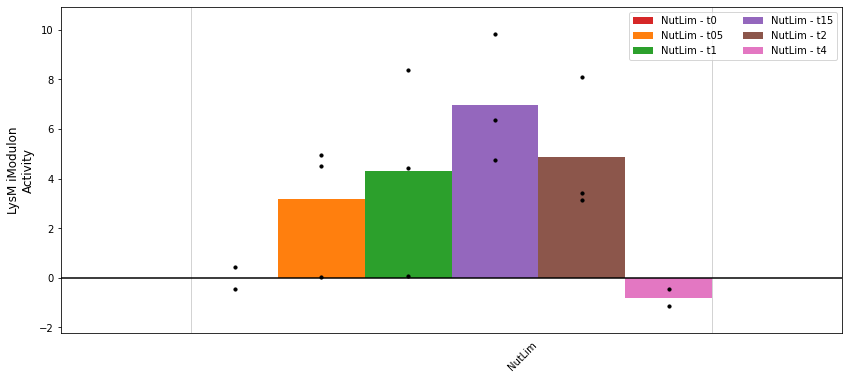

In [16]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'LysM',
                projects=['NutLim'],
                highlight=['NutLim'],
                ax=ax)

## iModulon 18: tfb3-dependent UV stress response iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='UV-tfb3 Gene Weight'>

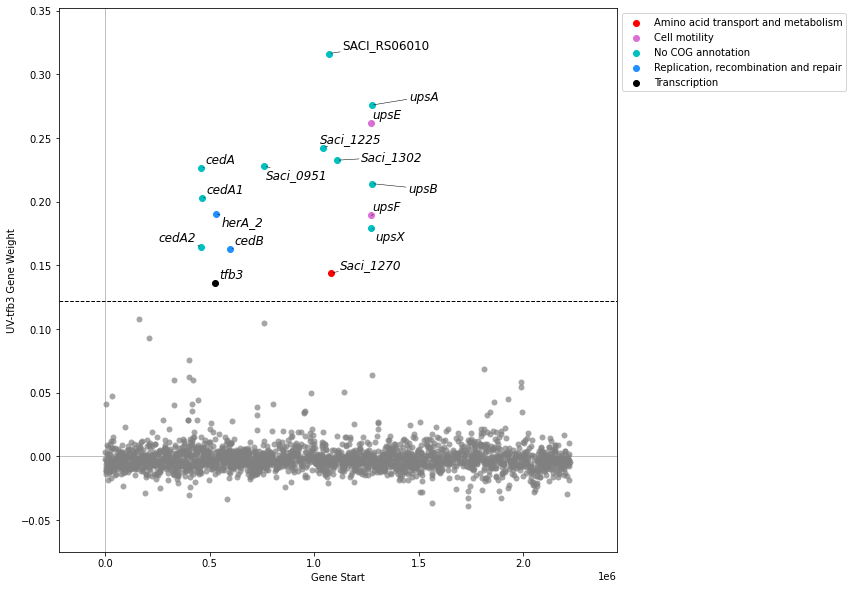

In [17]:
# Note that this iModulon contains the ups and ced systems
# It also contains uncharacterized genes, which we hypothesize
# belong to the as-yet-undiscovered Saci DNA export system.

fig, ax = plt.subplots(figsize=(10, 10))

plot_gene_weights(ica_data, 'UV-tfb3', ax=ax)

<AxesSubplot:ylabel='UV-tfb3 iModulon\nActivity'>

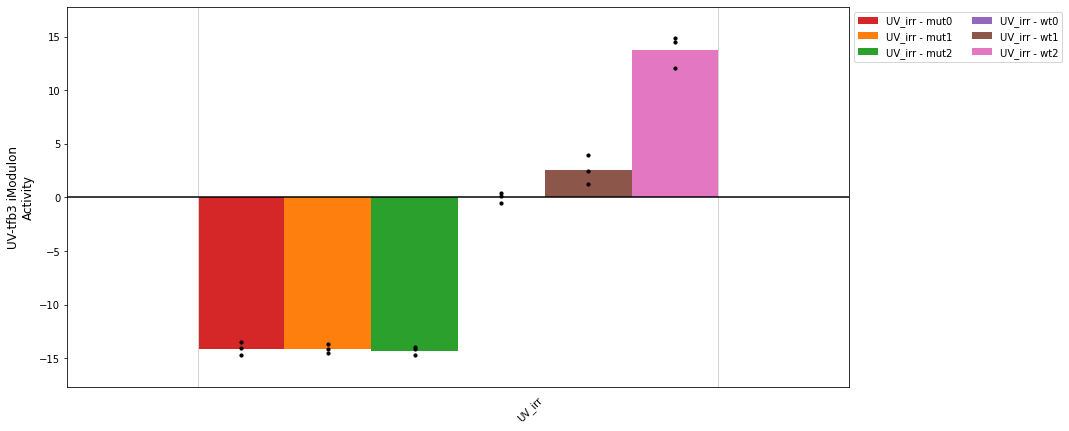

In [18]:
# The UV-irr project shows a time course between tfb3-disrupted mutants and wild-type
# There is a clear distinction between the mutants and wild-type, showing the tfb3 dependence
# for the genes in this iModulon

fig, ax = plt.subplots(figsize=(14, 7))

plot_activities(ica_data, 'UV-tfb3',projects='UV_irr', highlight='UV_irr', ax=ax)

# Note: ends with 0 = 0 min, ends with 1 = 45 min after UV, ends with 2 = 90 min after UV

---

# KEGG Enrichment iModulons

These iModulon closly match KEGG pathways/modules

## iModulon 4: Riboflavin (Vit B2) iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='Riboflavin Gene Weight'>

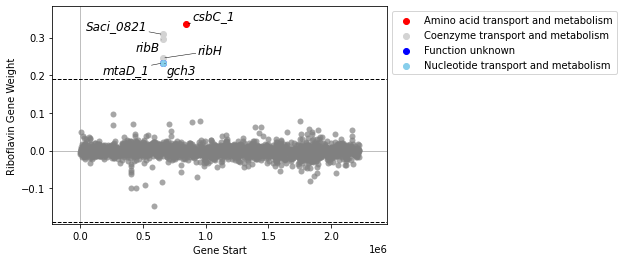

In [19]:
plot_gene_weights(ica_data, 'Riboflavin')

<AxesSubplot:ylabel='Riboflavin iModulon\nActivity'>

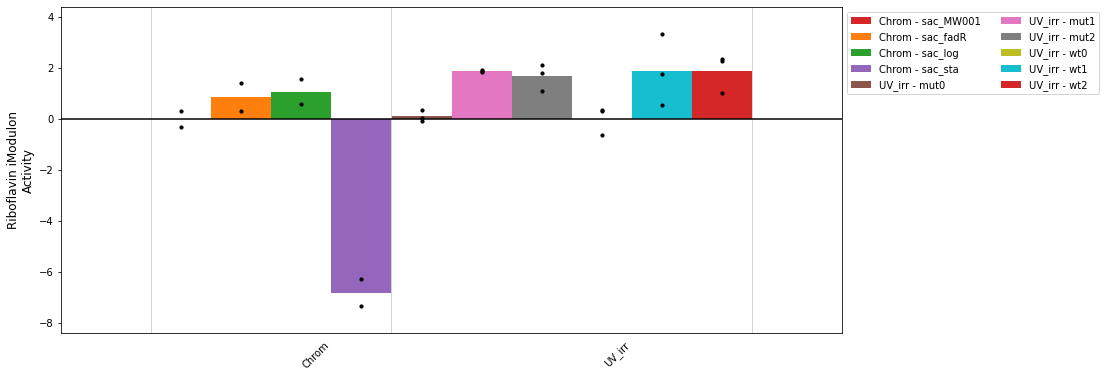

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Riboflavin', projects=['Chrom', 'UV_irr'], highlight=['Chrom', 'UV_irr'], ax=ax)

## iModulon 7: Carbon Fixation iModulon (3-HP / 4-HB cycle)

<AxesSubplot:xlabel='Gene Start', ylabel='carbon-fixation Gene Weight'>

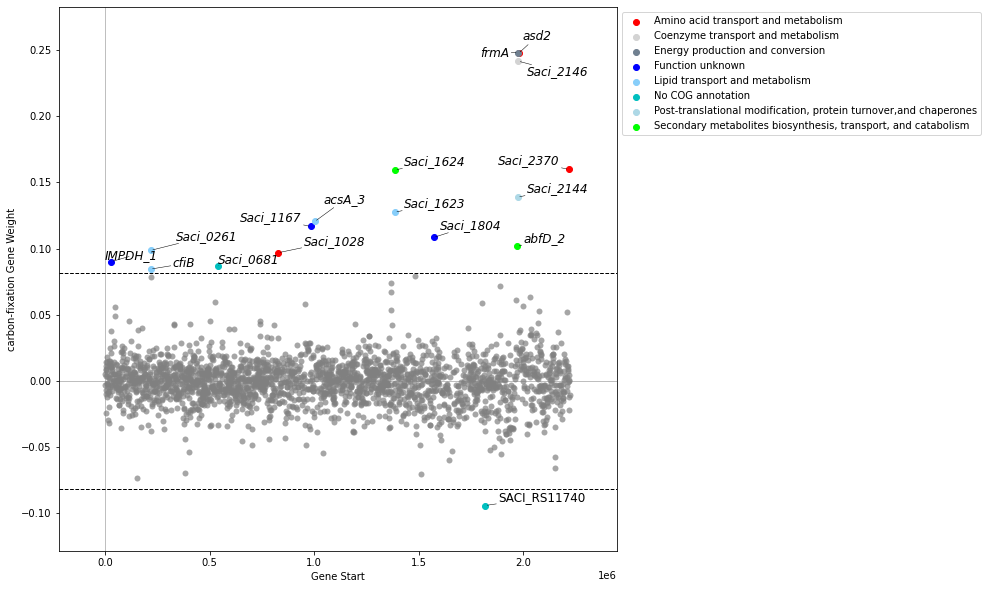

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_gene_weights(ica_data, 'carbon-fixation', ax=ax)

<AxesSubplot:ylabel='carbon-fixation iModulon\nActivity'>

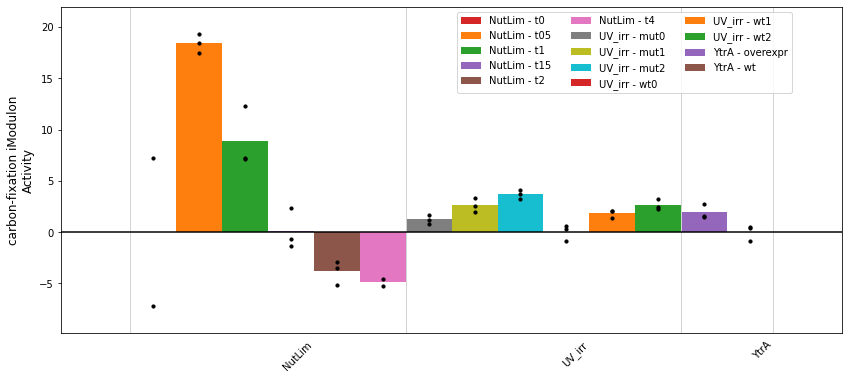

In [22]:
# Activity increases sharply 5 minutes after nutrient limitation,
# gradually drops down as time goes on

fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'carbon-fixation', projects=['NutLim', 'UV_irr', 'YtrA'], 
                highlight=['NutLim', 'UV_irr', 'YtrA'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.5, 1)})

## iModulon 9: HMG-CoA iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='HMG-CoA Gene Weight'>

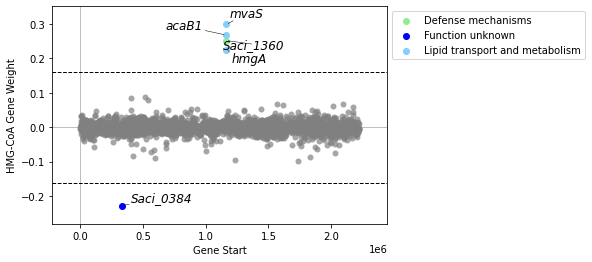

In [23]:
plot_gene_weights(ica_data, 'HMG-CoA')

<AxesSubplot:ylabel='HMG-CoA iModulon\nActivity'>

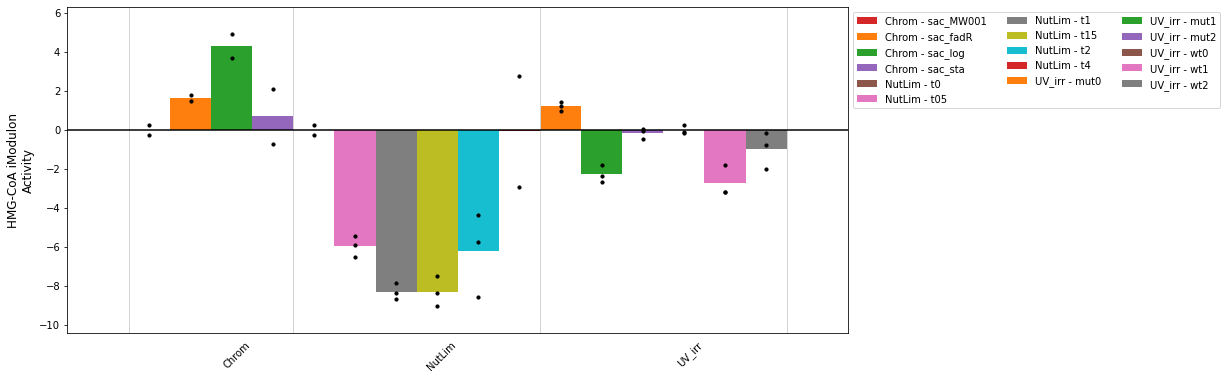

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'HMG-CoA', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

## iModulon 10: Purine biosynthesis iModulon [E coli ortholog: PurR-1]

<AxesSubplot:xlabel='Gene Start', ylabel='Purine Gene Weight'>

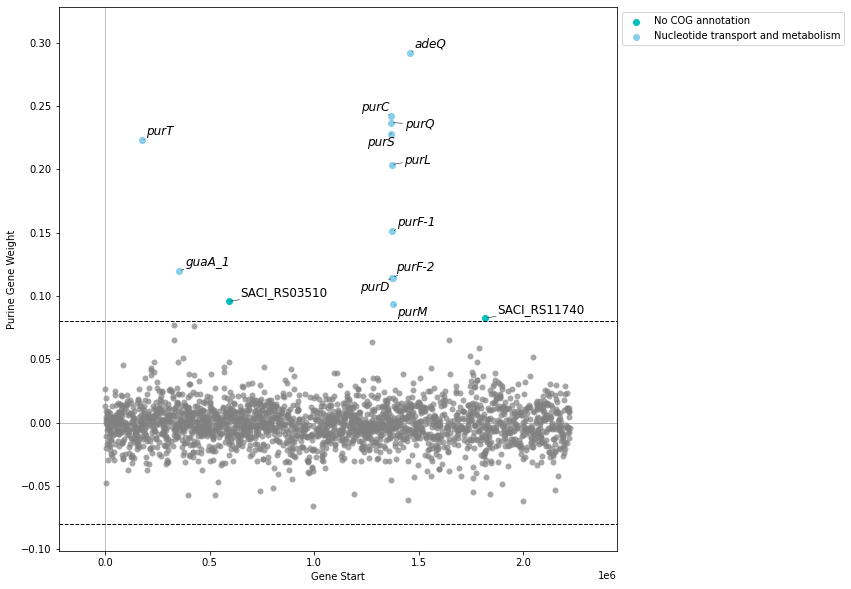

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_gene_weights(ica_data, 'Purine', ax=ax)

<AxesSubplot:ylabel='Purine iModulon\nActivity'>

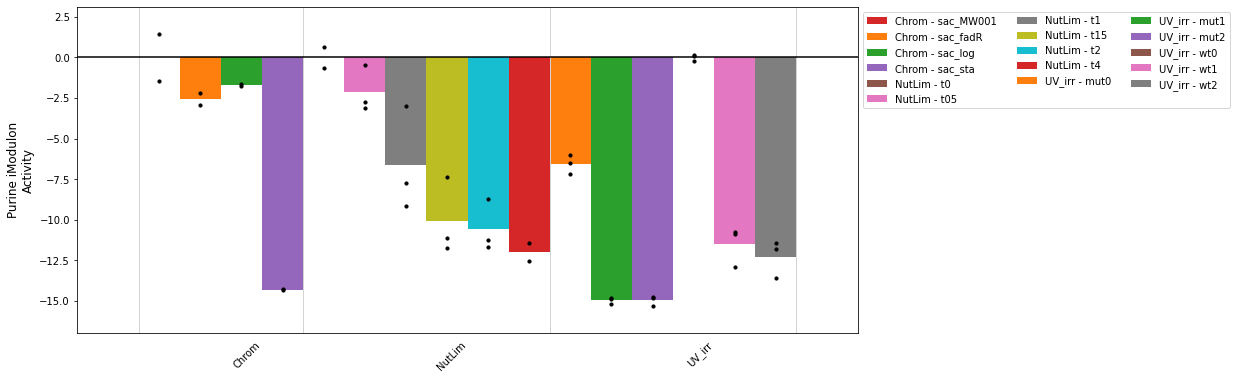

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Purine', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

## iModulon 17: Translation iModulon 1

<AxesSubplot:xlabel='Gene Start', ylabel='translation-1 Gene Weight'>

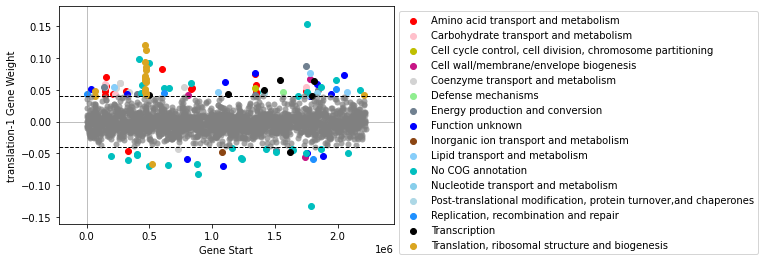

In [27]:
# iModulon has too many enriched genes to be shown in the plot
# The orange/yellow cluster that is enriched represents the
# ribosome gene cluster in the genome

plot_gene_weights(ica_data, 'translation-1')

<AxesSubplot:ylabel='translation-1 iModulon\nActivity'>

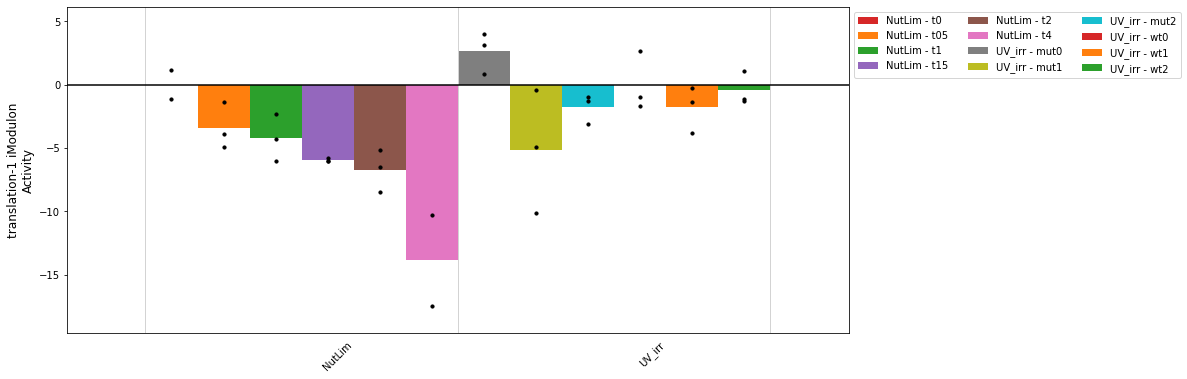

In [28]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'translation-1', projects=['NutLim', 'UV_irr'], highlight=['NutLim', 'UV_irr'], ax=ax)

## iModulon 19: Arginine biosynthesis iModulon [E coli ortholog: ArgR]

<AxesSubplot:xlabel='Gene Start', ylabel='Arginine Gene Weight'>

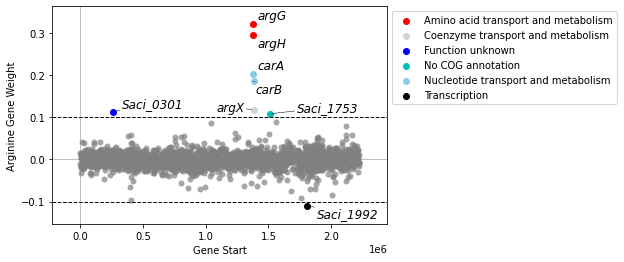

In [29]:
# Includes the additional genes that, combined with the LysM iModulon,
# are part of the Arginine biosynthesis pathways

plot_gene_weights(ica_data, 'Arginine')

<AxesSubplot:ylabel='Arginine iModulon\nActivity'>

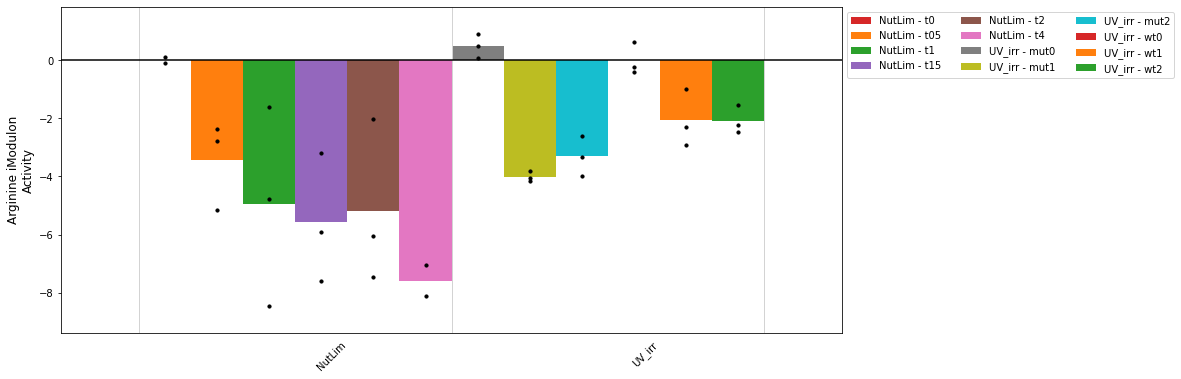

In [30]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Arginine', projects=['NutLim', 'UV_irr'], highlight=['NutLim', 'UV_irr'], ax=ax)

## iModulon 21: Translation iModulon 2

<AxesSubplot:xlabel='Gene Start', ylabel='translation-2 Gene Weight'>

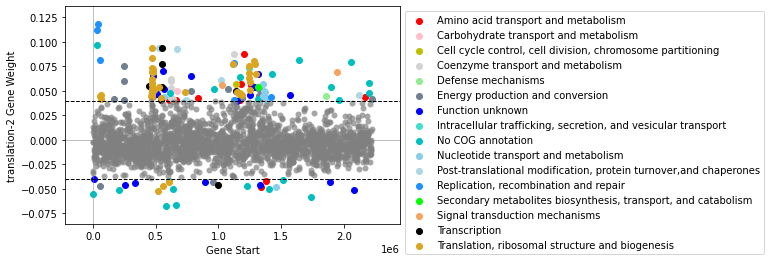

In [31]:
# This iModulon also contains the ribosome gene cluster
# as well as amino-acyl tRNA genes

plot_gene_weights(ica_data, 'translation-2')

<AxesSubplot:ylabel='translation-2 iModulon\nActivity'>

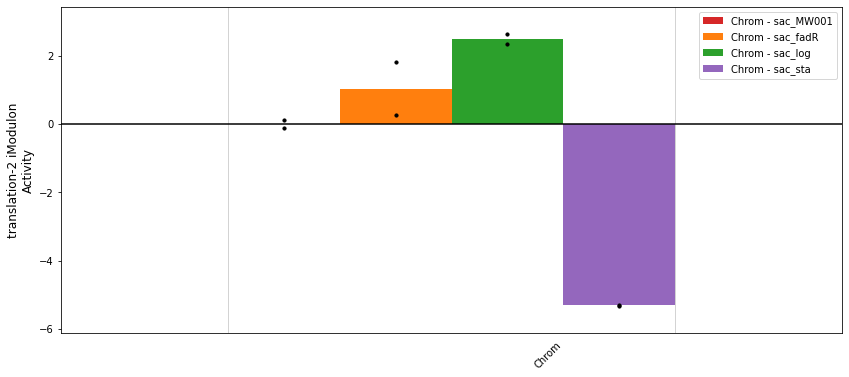

In [32]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'translation-2', projects=['Chrom'], highlight=['Chrom'], ax=ax)

## iModulon 23: Sulfur Assimilation iModulon [E coli Ortholog: CysB, translation]

<AxesSubplot:xlabel='Gene Start', ylabel='sulfur-assimilation Gene Weight'>

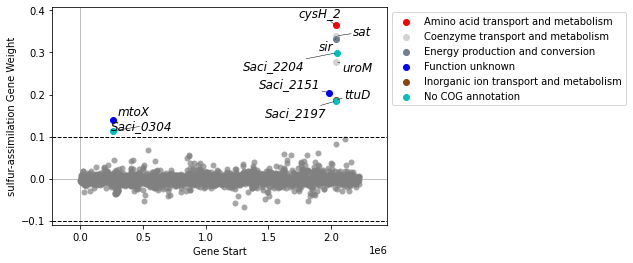

In [33]:
plot_gene_weights(ica_data, 'sulfur-assimilation')

<AxesSubplot:ylabel='sulfur-assimilation iModulon\nActivity'>

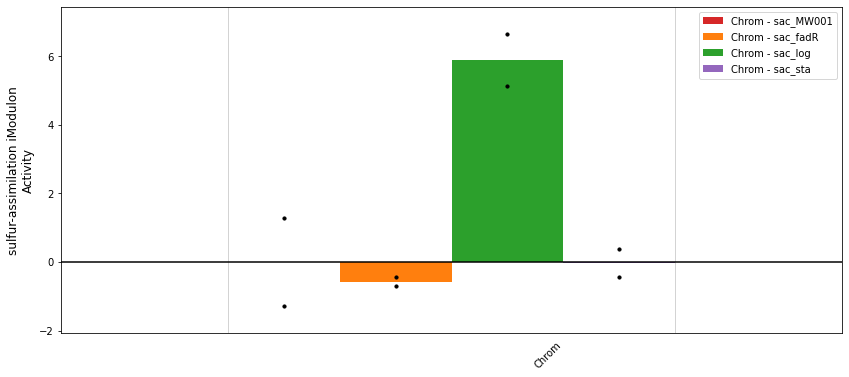

In [34]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'sulfur-assimilation', projects=['Chrom'], highlight=['Chrom'], ax=ax)

## iModulon 25: Cobalamin (Vit B12) iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='Cobalamin Gene Weight'>

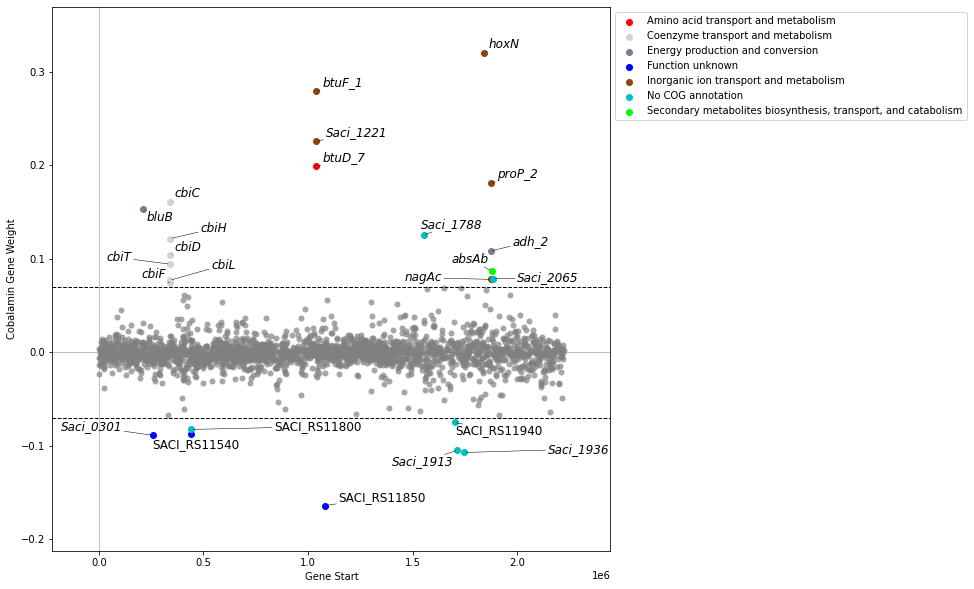

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_gene_weights(ica_data, 'Cobalamin', show_labels=True, ax=ax)

<AxesSubplot:ylabel='Cobalamin iModulon\nActivity'>

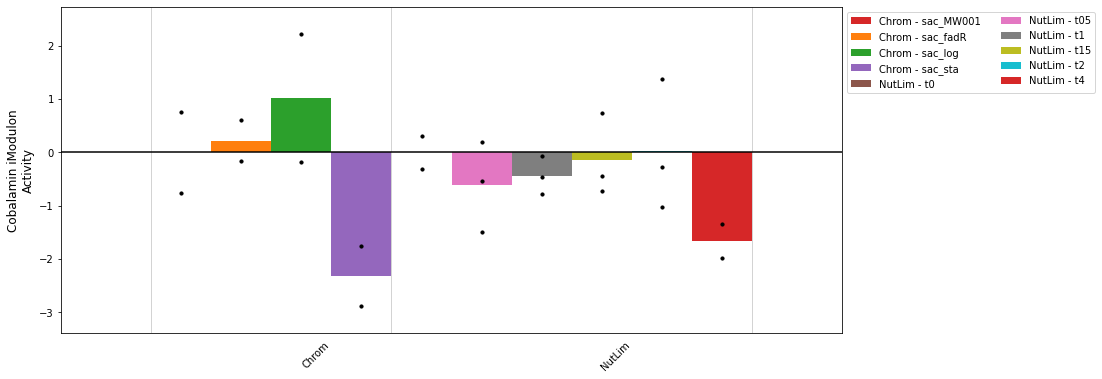

In [36]:
# The Chrom project is also included here, and is mainly useful in comparing iModulon activity
# between log and stationary phases

fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Cobalamin', projects=['Chrom', 'NutLim'], highlight=['Chrom', 'NutLim'], ax=ax)

## iModulon 26: 4-hydroxyphenylacetate degradation iModulon [E coli ortholog: NtrC+RpoN]

<AxesSubplot:xlabel='Gene Start', ylabel='4-HPA Gene Weight'>

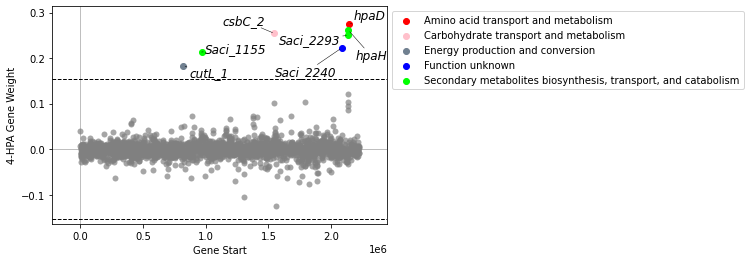

In [37]:
# iModulon is named after the operon near the end of the plot below
# which contains hpaH and hpaD, which code for the first committed step
# in 4-HPA degradation (as per UniProt)

plot_gene_weights(ica_data, '4-HPA')

<AxesSubplot:ylabel='4-HPA iModulon\nActivity'>

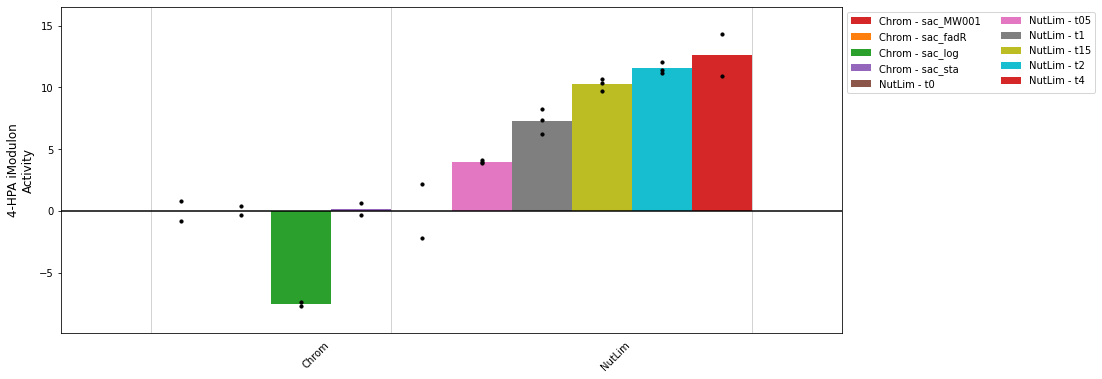

In [38]:
# Activity suggests this iModulon is upregulated during periods of nutrient limitation

fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, '4-HPA', projects=['Chrom', 'NutLim'], highlight=['Chrom', 'NutLim'], ax=ax)

## iModulon 31: TCA intermediates / BCAA metabolism iModulon [ E coli ortholog: Lrp]

<AxesSubplot:xlabel='Gene Start', ylabel='TCA-BCAA Gene Weight'>

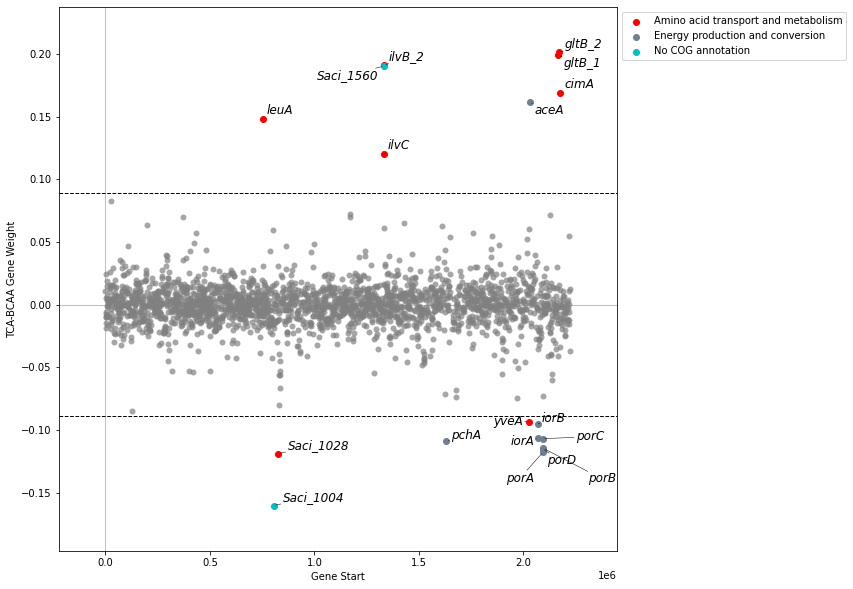

In [39]:
# Contains mostly TCA intermediates and genes that code for
# Leucine, Isoleucine, and Valine metabolism
# Saci_2320 and Saci_2321 in this iModulon
# (potentially regulated by BarR or some other Lrp-like regulator?)

fig, ax = plt.subplots(figsize=(10, 10))

plot_gene_weights(ica_data, 'TCA-BCAA', ax=ax)

<AxesSubplot:ylabel='TCA-BCAA iModulon\nActivity'>

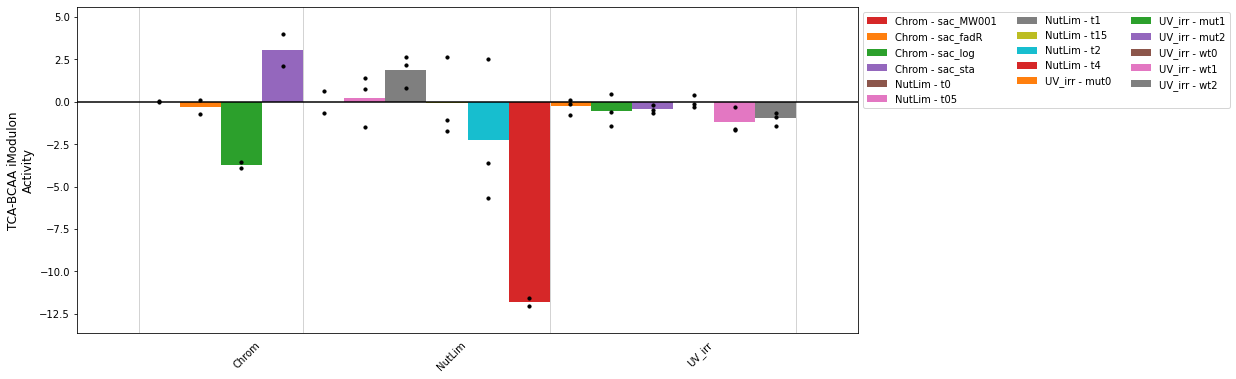

In [40]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'TCA-BCAA',projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

## iModulon 39: Carotenoid Biosynthesis iModulon [E coli ortholog: GlpR]

<AxesSubplot:xlabel='Gene Start', ylabel='carotenoid Gene Weight'>

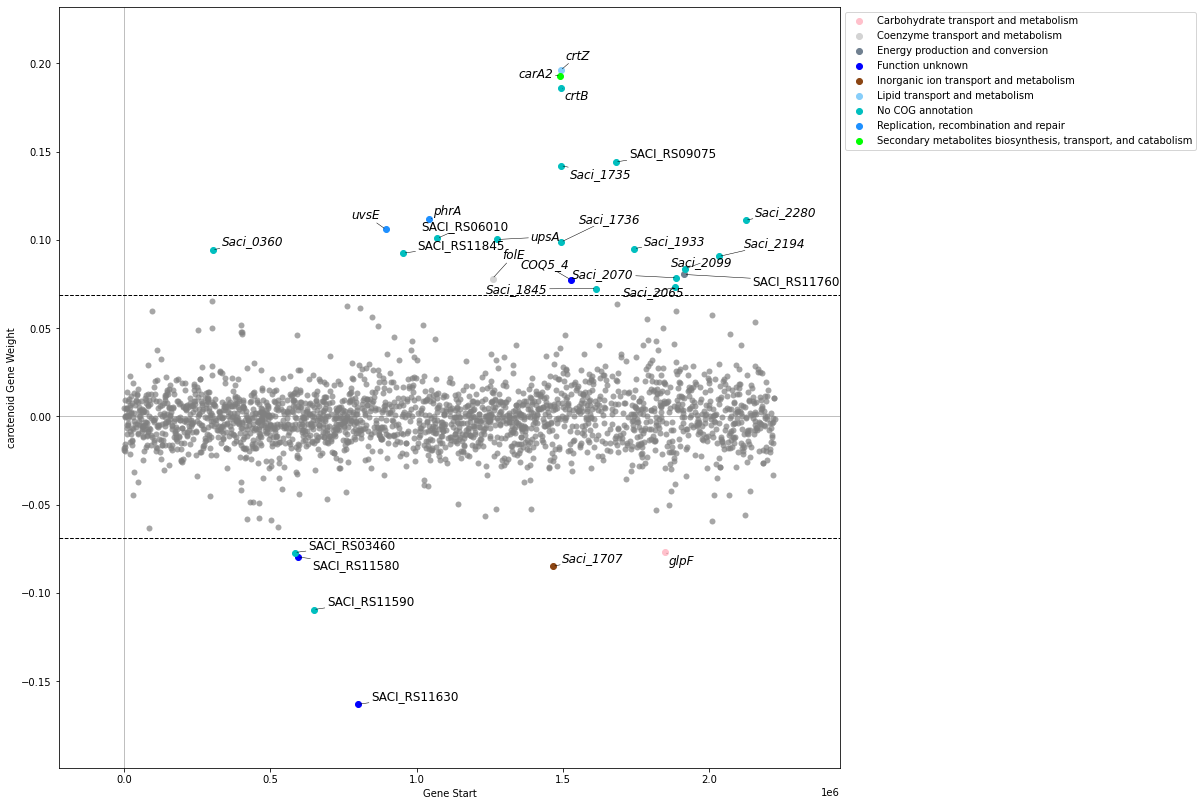

In [41]:
fig, ax = plt.subplots(figsize=(14, 14))

plot_gene_weights(ica_data, 'carotenoid', show_labels=True, ax=ax)

<AxesSubplot:ylabel='carotenoid iModulon\nActivity'>

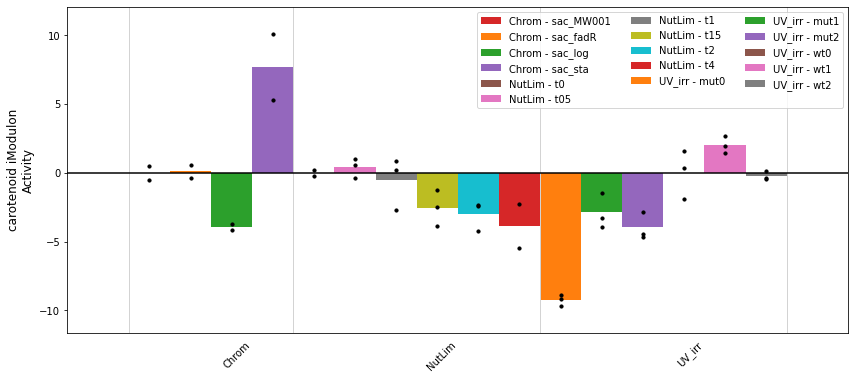

In [42]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'carotenoid',projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

---

# Remaining iModulons

## iModulon 0: pseudogene iModulon

* According to Biocyc SACI_RS05165 is a frame-shifted pseudogene

<AxesSubplot:xlabel='Gene Start', ylabel='pseudogene Gene Weight'>

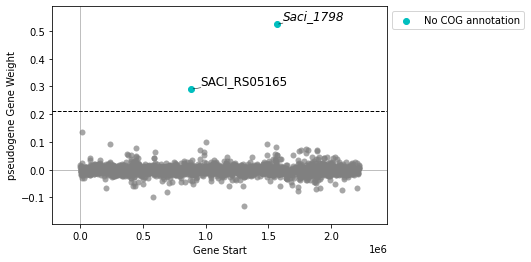

In [43]:
plot_gene_weights(ica_data, 'pseudogene')

<AxesSubplot:ylabel='pseudogene iModulon\nActivity'>

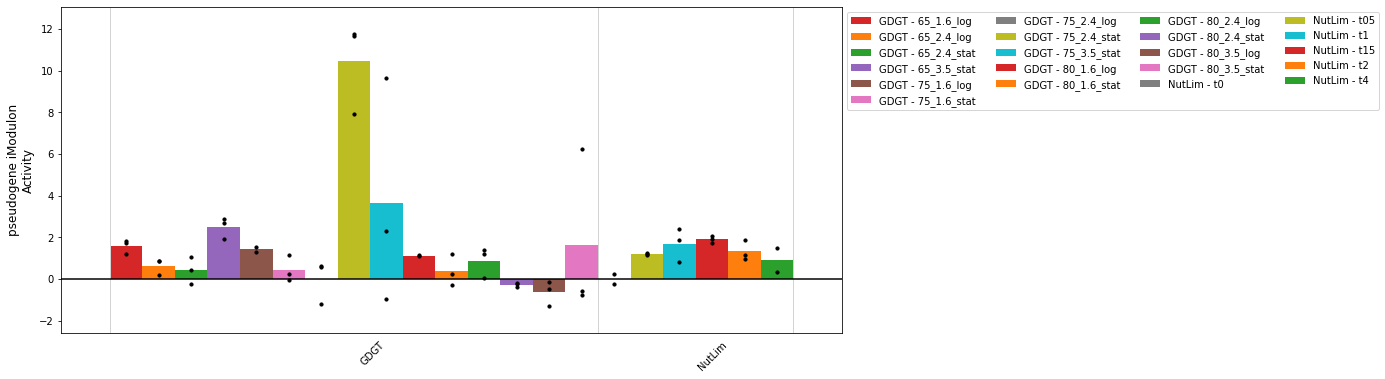

In [44]:
# 75 C, 3.5 pH, stationary phase & 80 C, 3.5 pH, stationary phase also show some odd activity
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'pseudogene', projects=['GDGT', 'NutLim'], highlight=['GDGT', 'NutLim'], ax=ax)

## iModulon 1: heat-stress iModulon (different from heat-shock)

<AxesSubplot:xlabel='Gene Start', ylabel='heat-stress Gene Weight'>

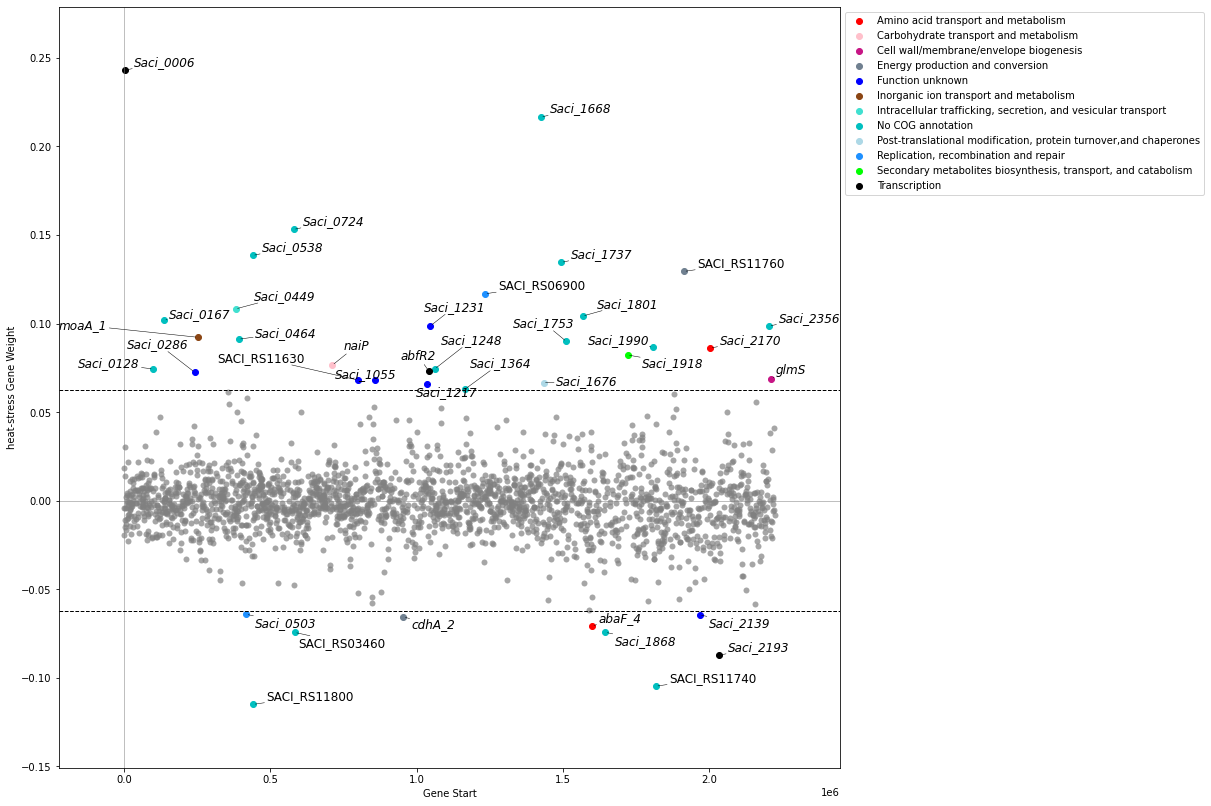

In [45]:
fig, ax = plt.subplots(figsize=(14, 14))

plot_gene_weights(ica_data, 'heat-stress', show_labels=True, ax=ax)

<AxesSubplot:xlabel='heat-stress'>

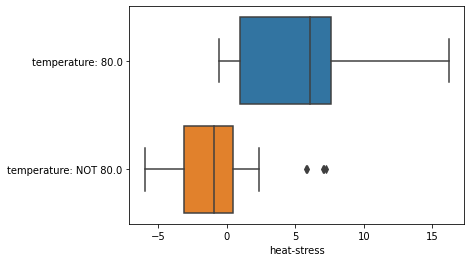

In [46]:
metadata_boxplot(ica_data, 'heat-stress', n_boxes=2)

<AxesSubplot:ylabel='heat-stress iModulon\nActivity'>

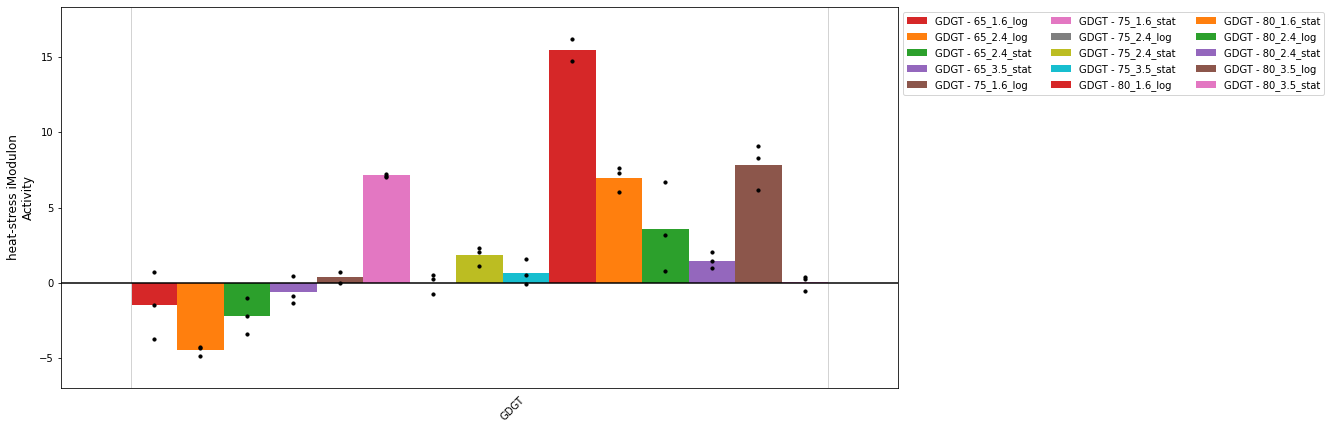

In [47]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 'heat-stress', projects='GDGT', highlight='GDGT', ax=ax)

## iModulon 2: Archaeal Coenzyme Q / cytochrome bc1 complex iModulon SoxL2N [E coli Ortholog: OxyR]

<AxesSubplot:xlabel='Gene Start', ylabel='SoxL2N Gene Weight'>

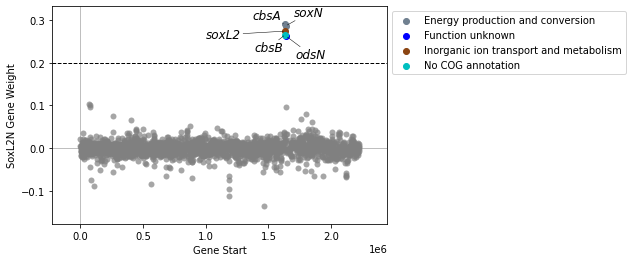

In [48]:
plot_gene_weights(ica_data, 'SoxL2N')

<AxesSubplot:xlabel='SoxL2N'>

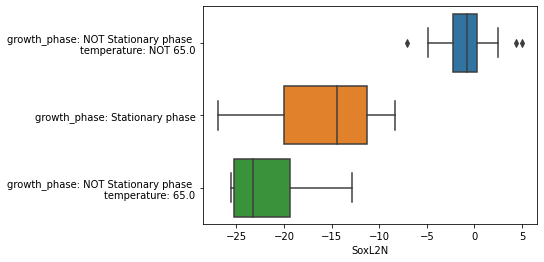

In [49]:
# Here we introduce the metadata boxplot
# This boxplot shows the activity of the iModulon based on metadata
# of collected experiments in dataset
# This boxplot shows a relationship with this iModulon
# between log and stationary phases, in addition to
# much lower activity at 65 C, log phase


metadata_boxplot(ica_data, 'SoxL2N')

<AxesSubplot:ylabel='SoxL2N iModulon\nActivity'>

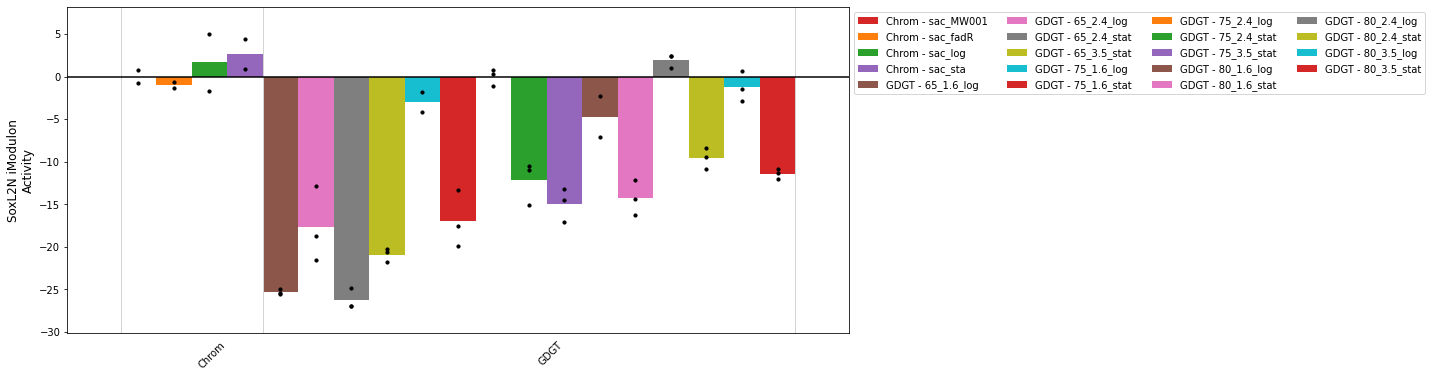

In [50]:
# This activity plot recapitulates what is shown in the boxplot above
# GDGT is a project that shows activities of Saci at differing
# temperature, pH level, and log/stat phases

# Temps tested: 65 C, 75 C, 80 C
# pH levels used: 1.6, 2.4, 3.5
# phases used: log, stat

fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'SoxL2N', projects=['Chrom', 'GDGT'], highlight=['Chrom', 'GDGT'], ax=ax)

## iModulon 3: Long-Chain Fatty-Acid iModulon

* Contains Saci_2137, a known gene regulated by Saci_2136 (barR)
* Potentially regulated by BarR or BarR-like TF
* Called 'long-chain-fatty-acid' as it contains 2 long-chain acyl-CoA gene products

<AxesSubplot:xlabel='Gene Start', ylabel='long-chain-fatty-acid Gene Weight'>

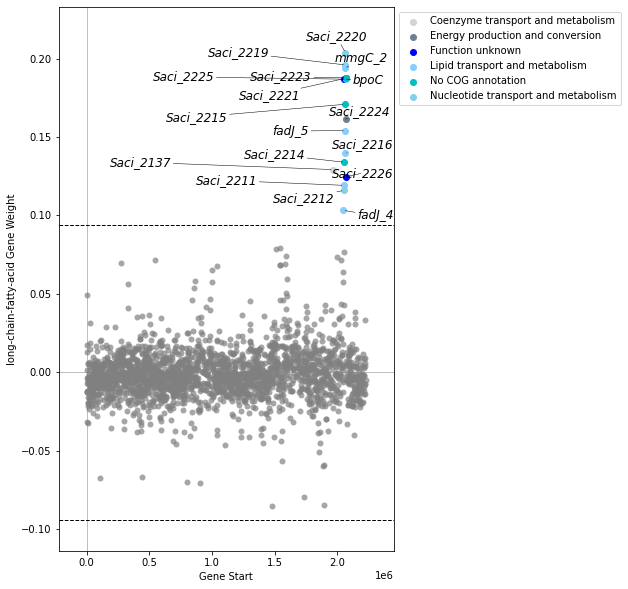

In [51]:
fig, ax = plt.subplots(figsize=(6, 10))

plot_gene_weights(ica_data, 'long-chain-fatty-acid', ax=ax)

<AxesSubplot:xlabel='long-chain-fatty-acid'>

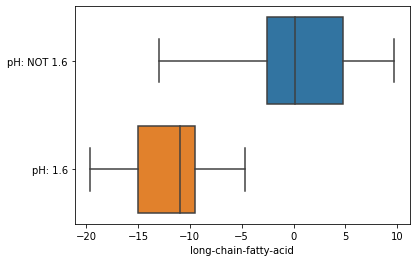

In [52]:
# There is an acid-stress dependence
metadata_boxplot(ica_data, 'long-chain-fatty-acid', n_boxes=2)

<AxesSubplot:ylabel='long-chain-fatty-acid iModulon\nActivity'>

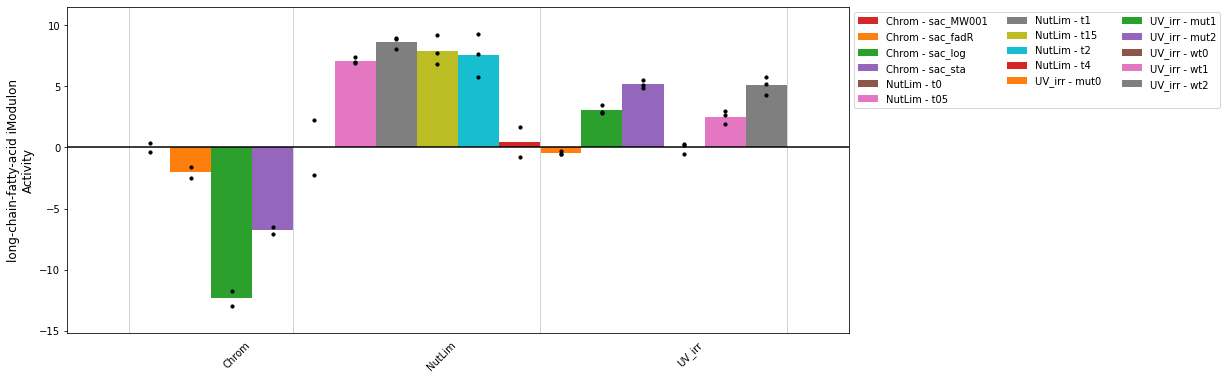

In [53]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'long-chain-fatty-acid', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

<AxesSubplot:ylabel='long-chain-fatty-acid iModulon\nActivity'>

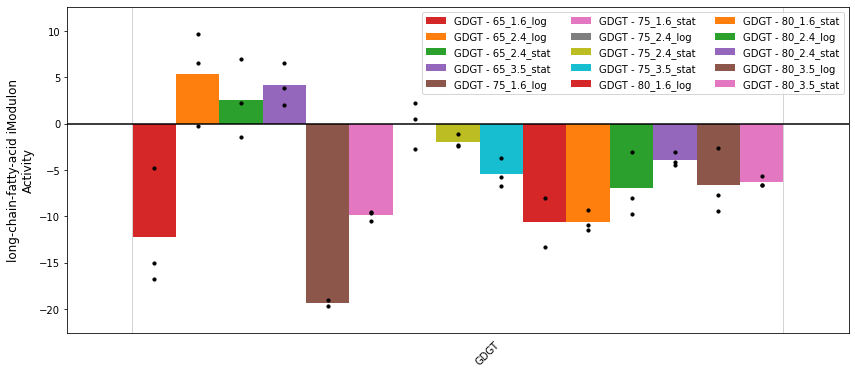

In [54]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'long-chain-fatty-acid', projects='GDGT', highlight='GDGT', ax=ax)

## iModulon 5: Niacin (Vitamin B3) transport iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='niacin-transport Gene Weight'>

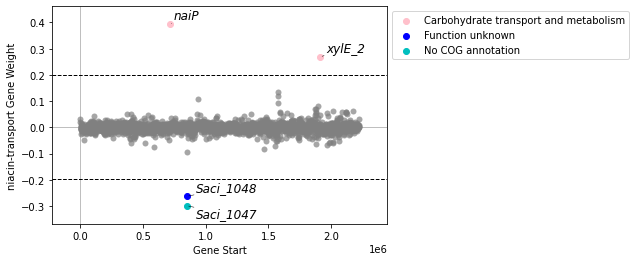

In [55]:
plot_gene_weights(ica_data, 'niacin-transport')

<AxesSubplot:xlabel='niacin-transport'>

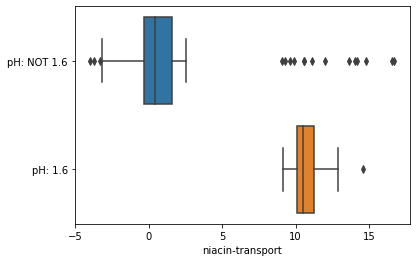

In [56]:
metadata_boxplot(ica_data, 'niacin-transport', n_boxes=2)

<AxesSubplot:ylabel='niacin-transport iModulon\nActivity'>

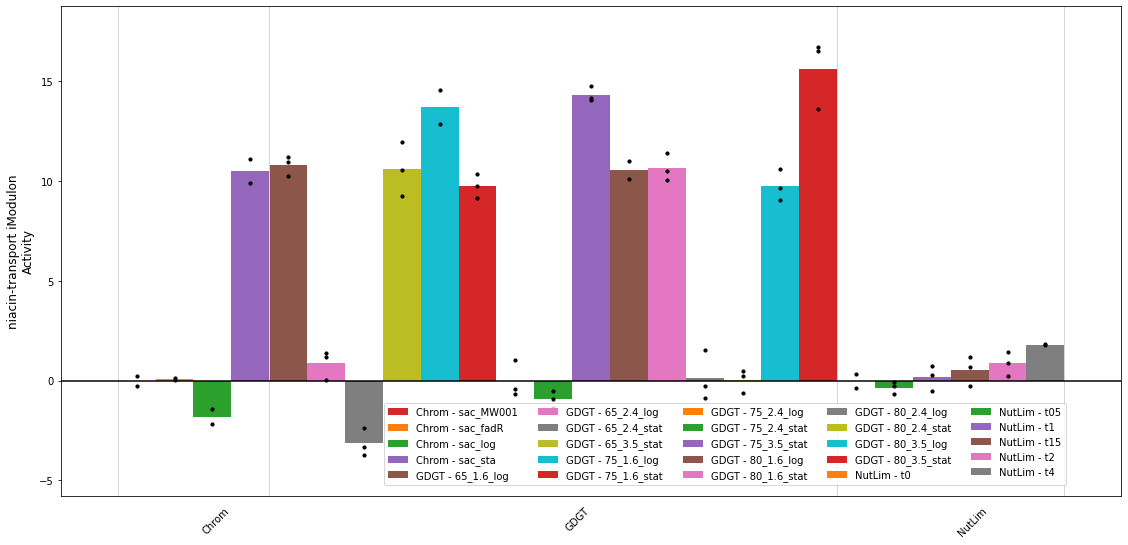

In [57]:
fig, ax = plt.subplots(figsize=(19, 9))

plot_activities(ica_data, 'niacin-transport', projects=['Chrom', 'GDGT', 'NutLim'],
                highlight=['Chrom', 'GDGT', 'NutLim'], ax=ax,
                legend_kwargs={'bbox_to_anchor': (0.3, 0.2)})

## iModulon 6: cold-stress iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='cold-stress Gene Weight'>

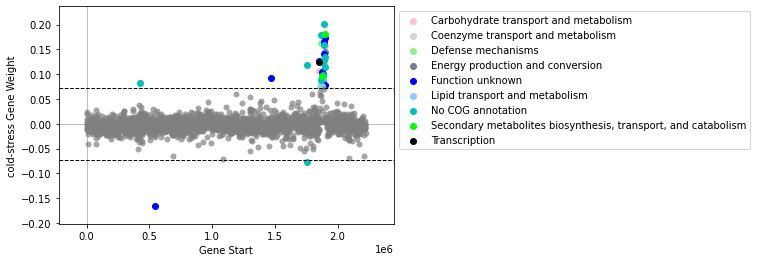

In [58]:
# Saci_2034 to Saci_2085 gene cluster
plot_gene_weights(ica_data, 'cold-stress')

<AxesSubplot:xlabel='cold-stress'>

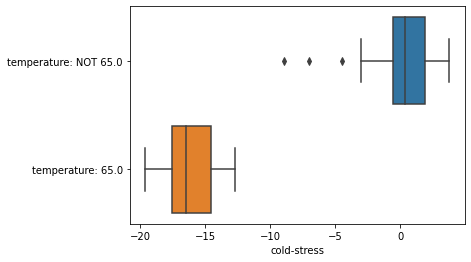

In [59]:
metadata_boxplot(ica_data, 'cold-stress', n_boxes=2)

<AxesSubplot:ylabel='cold-stress iModulon\nActivity'>

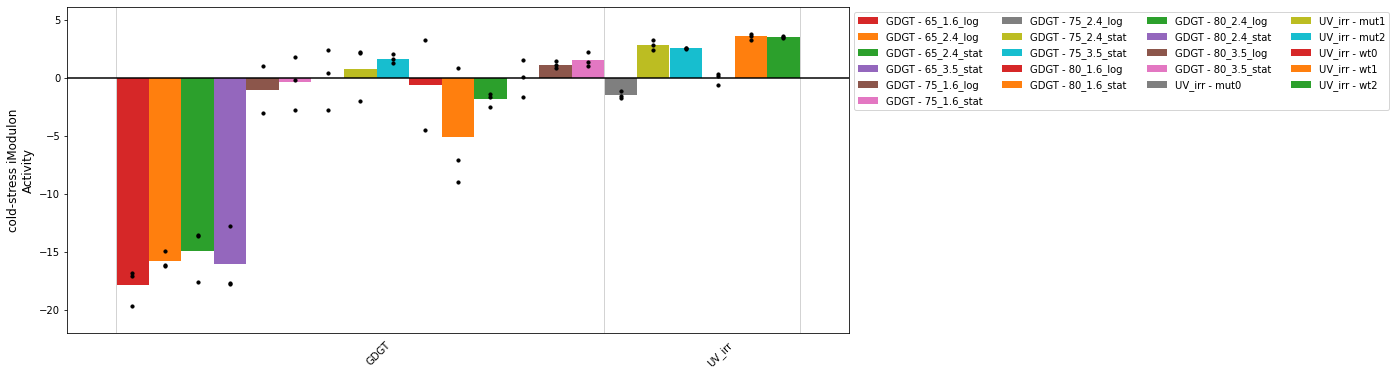

In [60]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'cold-stress', projects=['GDGT', 'UV_irr'], highlight=['GDGT', 'UV_irr'], ax=ax)

## iModulon 8: Iron-Sulfur-Lipoylation-Associated iModulon

Many iron-sulfur related genes

Many lipoylation/acyl-lipid-carrier proteins

<AxesSubplot:xlabel='Gene Start', ylabel='Fe-S-lipoylation Gene Weight'>

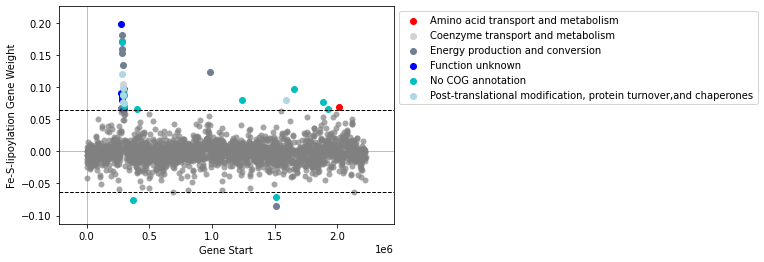

In [61]:
# Saci_320 to Saci_353 gene cluster near the beginning
plot_gene_weights(ica_data, 'Fe-S-lipoylation')

<AxesSubplot:ylabel='Fe-S-lipoylation iModulon\nActivity'>

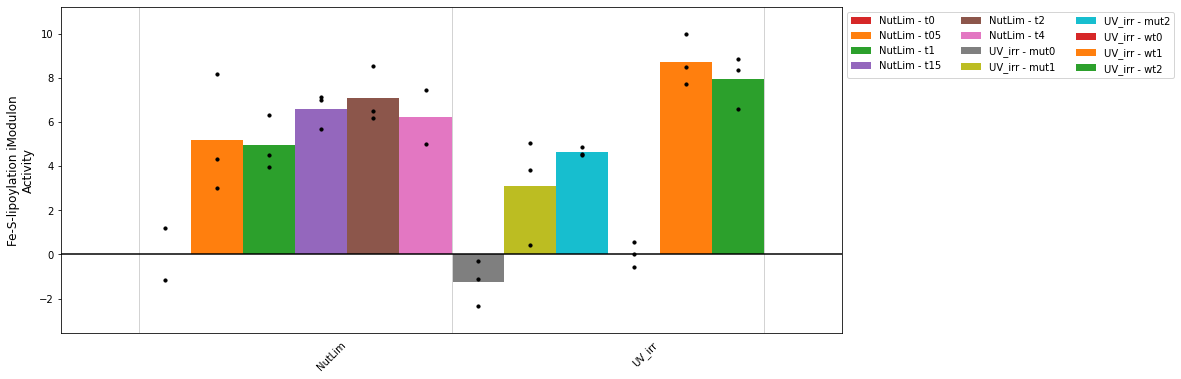

In [62]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Fe-S-lipoylation', projects=['NutLim', 'UV_irr'],
                highlight=['NutLim', 'UV_irr'], ax=ax)

## iModulon 14: Phenylacetate Degradation iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='Phenylacetate Gene Weight'>

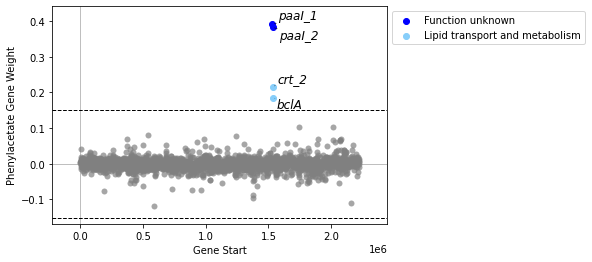

In [63]:
plot_gene_weights(ica_data, 'Phenylacetate')

<AxesSubplot:ylabel='Phenylacetate iModulon\nActivity'>

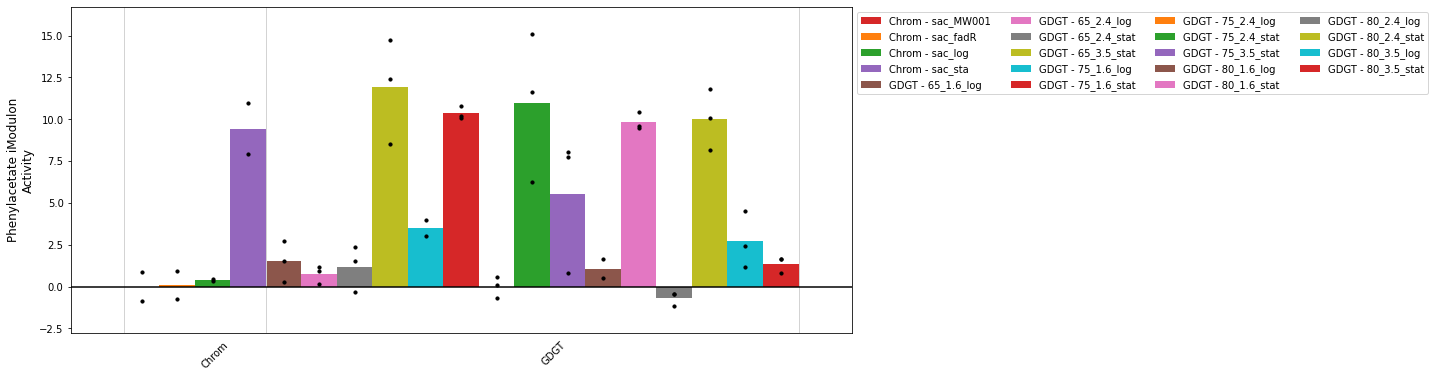

In [64]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Phenylacetate', projects=['Chrom','GDGT'], highlight=['Chrom', 'GDGT'], ax=ax)

<AxesSubplot:ylabel='Phenylacetate iModulon\nActivity'>

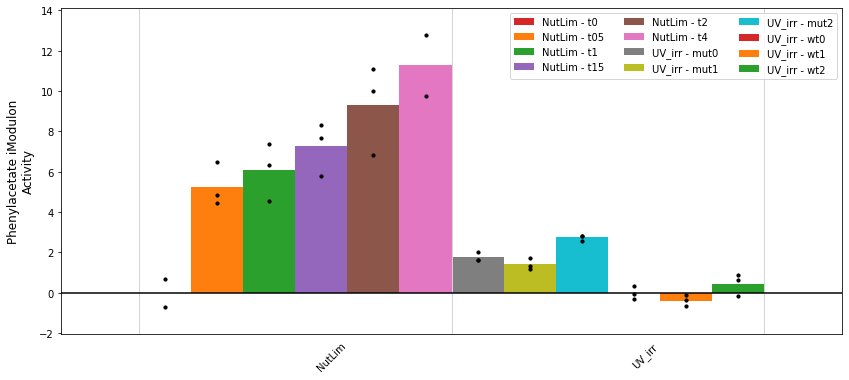

In [65]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Phenylacetate', projects=['NutLim', 'UV_irr'],
                highlight=['NutLim', 'UV_irr'], ax=ax)

### iModulon 15: single_gene_1 (Uncharacterized iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='single_gene_1 Gene Weight'>

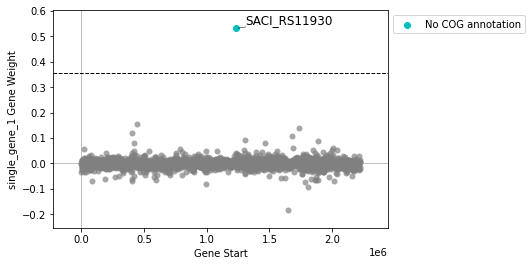

In [66]:
# Unlike the FadR-KO iModulon, this single-gene iModulon has no known information on it
# and may be a result of slight overdecomposition (brought on by lack of RNA-seq data)
# With more data, these single-gene iModulons may actually disappear into other iModulons.

plot_gene_weights(ica_data, 'single_gene_1')

In [67]:
ica_data.view_imodulon('single_gene_1')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11930     0.530262  SACI_RS11930           NaN              NaN   

             synonyms      start        end strand          gene_product  \
SACI_RS11930      NaN  1235099.0  1235239.0      -  hypothetical protein   

             gene_product_prokka                COG        uniprot  \
SACI_RS11930                 NaN  No COG annotation  UPI0012D9D522   

                   refseq regulator  
SACI_RS11930  NC_007181.1       NaN

### iModulon 16: single_gene_2 (Uncharacterized iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='single_gene_2 Gene Weight'>

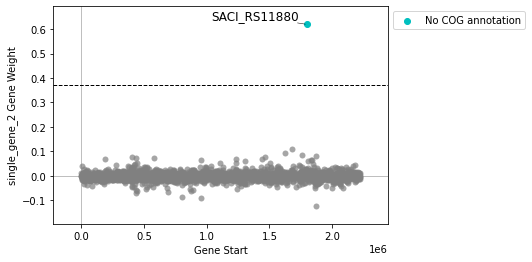

In [68]:
plot_gene_weights(ica_data, 'single_gene_2')

In [69]:
ica_data.view_imodulon('single_gene_2')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11880      0.61887  SACI_RS11880           NaN              NaN   

             synonyms      start        end strand         gene_product  \
SACI_RS11880      NaN  1802184.0  1802258.0      +  PIN domain nuclease   

             gene_product_prokka                COG uniprot       refseq  \
SACI_RS11880                 NaN  No COG annotation     NaN  NC_007181.1   

             regulator  
SACI_RS11880       NaN

## iModulon 20: Hydtanoinase-acetophenone based iModulon [E coli ortholog: Nac, Pur-2]

- Putative Nitrogen Starvation / Aromatic degradation / Antibiotic production iModulon

- Operon from Saci_2036 to Saci_2042 (excluding Saci_2040)

- Saci_2040 is a predicted TF [uniprot] and is missing from this operon (potential regulator of this operon?)

- Possible Glutathione iModulon?

    - https://pubmed.ncbi.nlm.nih.gov/29667297/

<AxesSubplot:xlabel='Gene Start', ylabel='Hydtanoinase-acetophenone Gene Weight'>

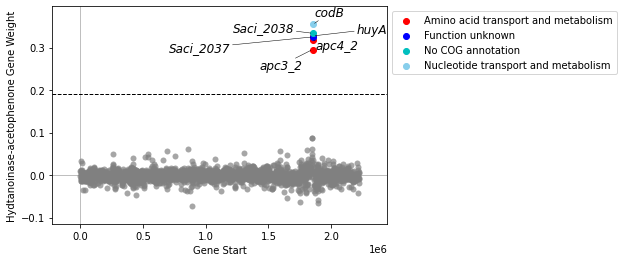

In [70]:
plot_gene_weights(ica_data, 'Hydtanoinase-acetophenone')

<AxesSubplot:xlabel='Hydtanoinase-acetophenone'>

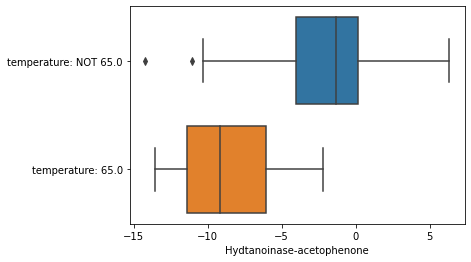

In [71]:
metadata_boxplot(ica_data, 'Hydtanoinase-acetophenone', n_boxes=2)

<AxesSubplot:ylabel='Hydtanoinase-acetophenone iModulon\nActivity'>

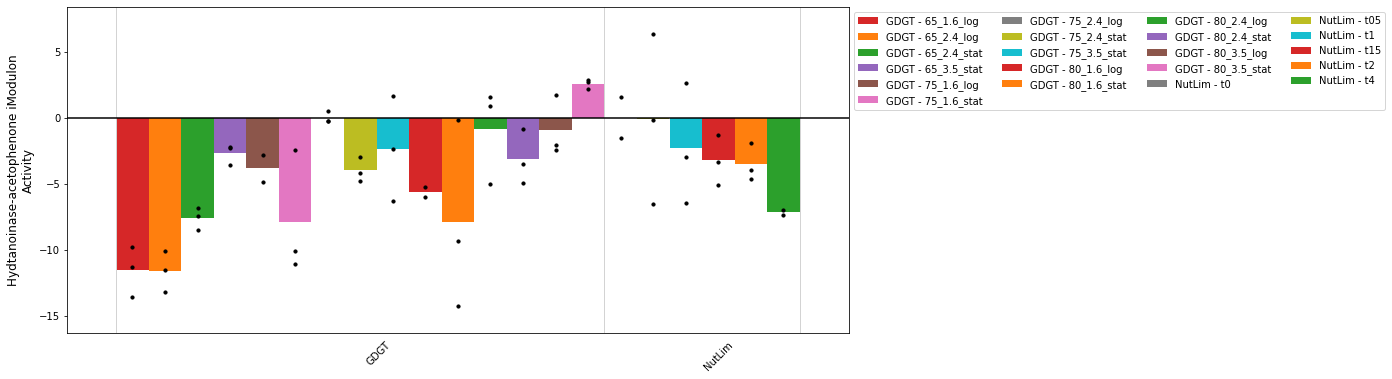

In [72]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Hydtanoinase-acetophenone', projects=['GDGT', 'NutLim'],
                highlight=['GDGT', 'NutLim'], ax=ax)

## iModulon 22: Uncharacterized iModulon 1

- 3 integrases and 1 PIN domain endonuclease
- Potentially from a virus?
- temperature dependence furthers virus possibility

<AxesSubplot:xlabel='Gene Start', ylabel='unchar-1 Gene Weight'>

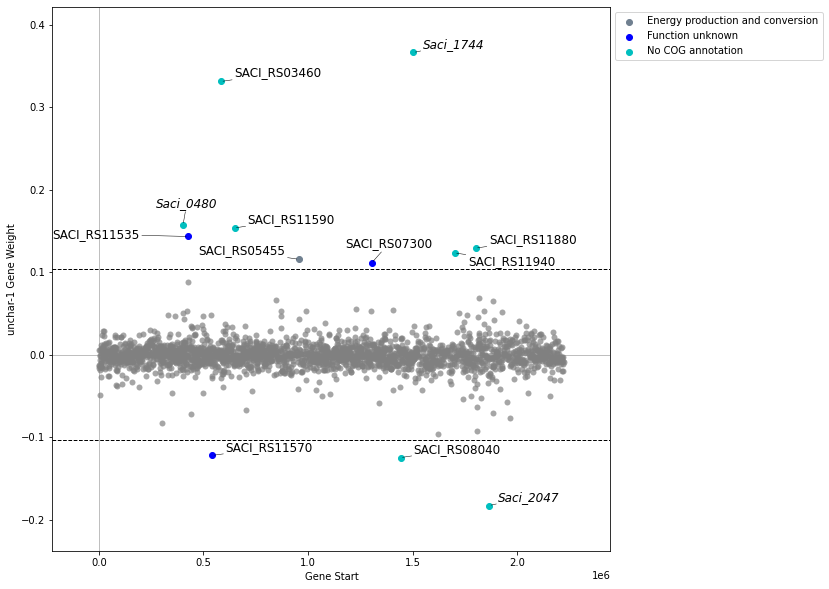

In [73]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_gene_weights(ica_data, 'unchar-1', ax=ax)

<AxesSubplot:xlabel='unchar-1'>

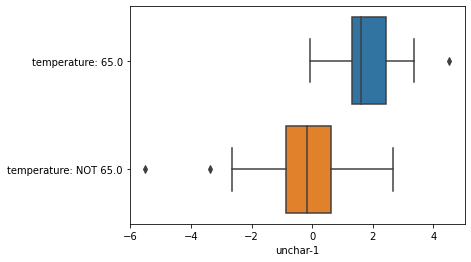

In [74]:
# Temperature dependence perhaps hints at virus relation?

metadata_boxplot(ica_data, 'unchar-1', n_boxes=2)

<AxesSubplot:ylabel='niacin-transport iModulon\nActivity'>

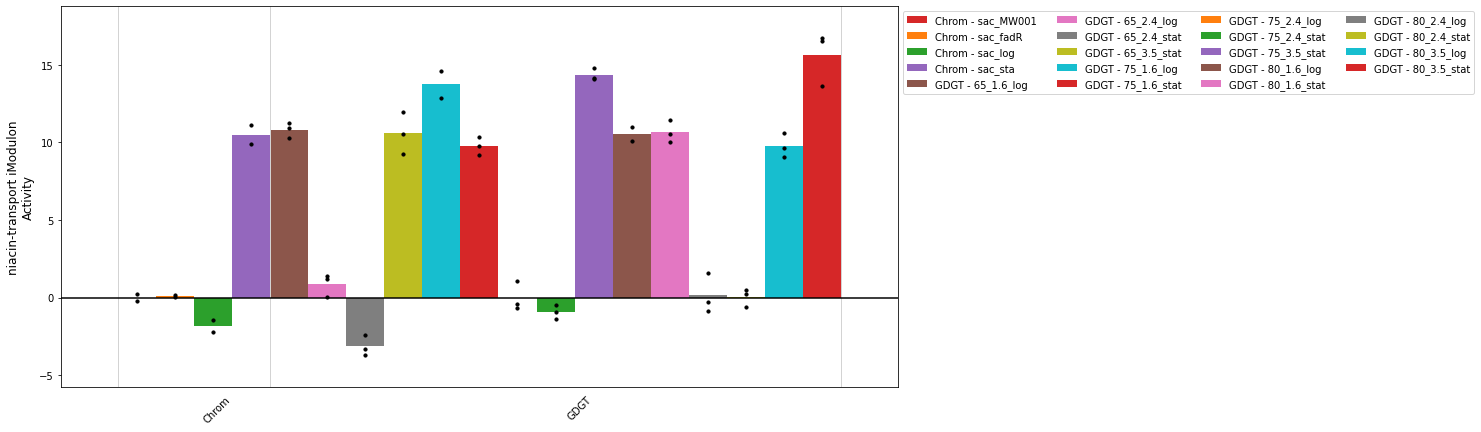

In [75]:
fig, ax = plt.subplots(figsize=(15, 7))

plot_activities(ica_data, 'niacin-transport', projects=['Chrom', 'GDGT'],
                highlight=['Chrom', 'GDGT'], ax=ax)

## iModulon 28: single_gene_3 (Uncharacterized iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='single_gene_3 Gene Weight'>

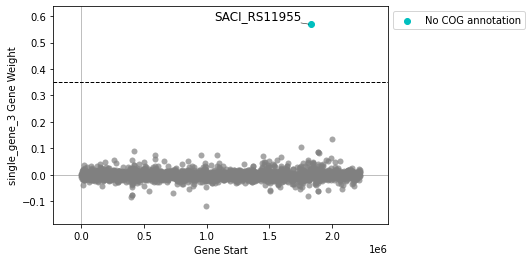

In [76]:
plot_gene_weights(ica_data, 'single_gene_3')

In [77]:
ica_data.view_imodulon('single_gene_3')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11955     0.568018  SACI_RS11955           NaN              NaN   

             synonyms      start        end strand          gene_product  \
SACI_RS11955      NaN  1829337.0  1829474.0      +  hypothetical protein   

             gene_product_prokka                COG        uniprot  \
SACI_RS11955                 NaN  No COG annotation  UPI000AA94FC4   

                   refseq regulator  
SACI_RS11955  NC_007181.1       NaN

## iModulon 30: Cytochrome reductase (SoxLABCD) iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='SoxLABCD Gene Weight'>

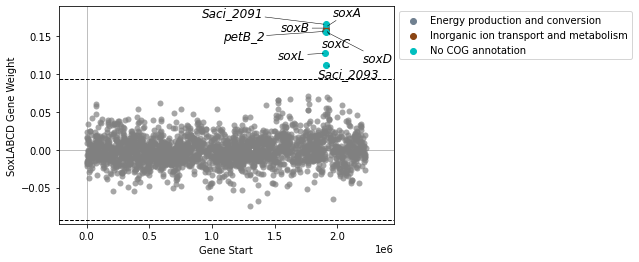

In [78]:
plot_gene_weights(ica_data, 'SoxLABCD')

<AxesSubplot:ylabel='SoxLABCD iModulon\nActivity'>

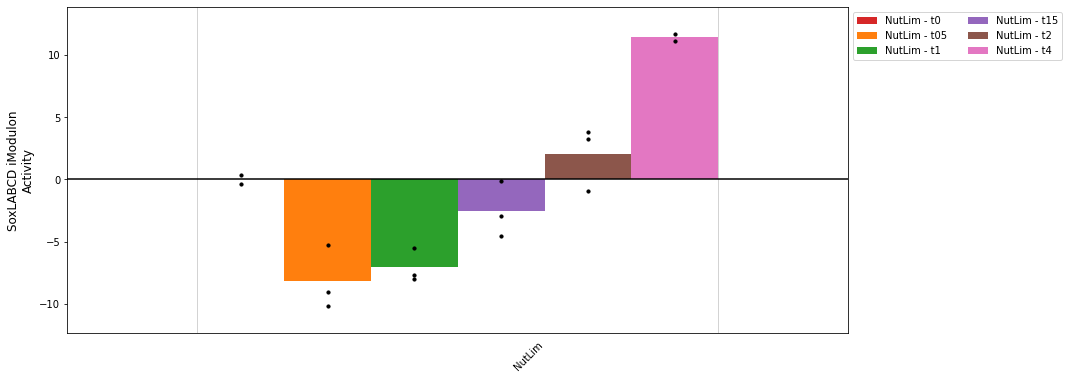

In [79]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'SoxLABCD', projects=['NutLim'], highlight=['NutLim'], ax=ax)

## iModulon 32: UV Stress Related iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='UV-related Gene Weight'>

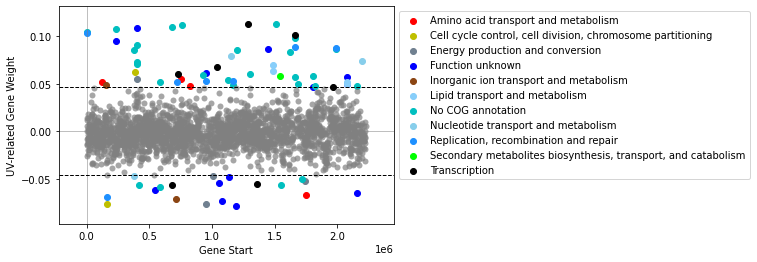

In [80]:
plot_gene_weights(ica_data, 'UV-related')

<AxesSubplot:xlabel='UV-related'>

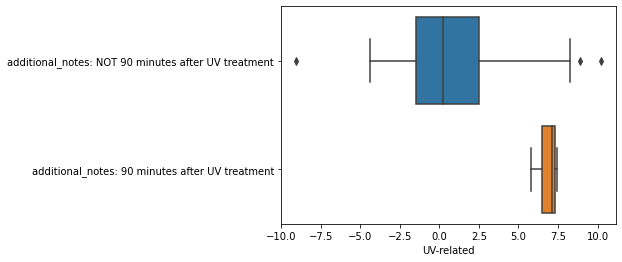

In [81]:
metadata_boxplot(ica_data, 'UV-related', n_boxes=2)

<AxesSubplot:ylabel='UV-related iModulon\nActivity'>

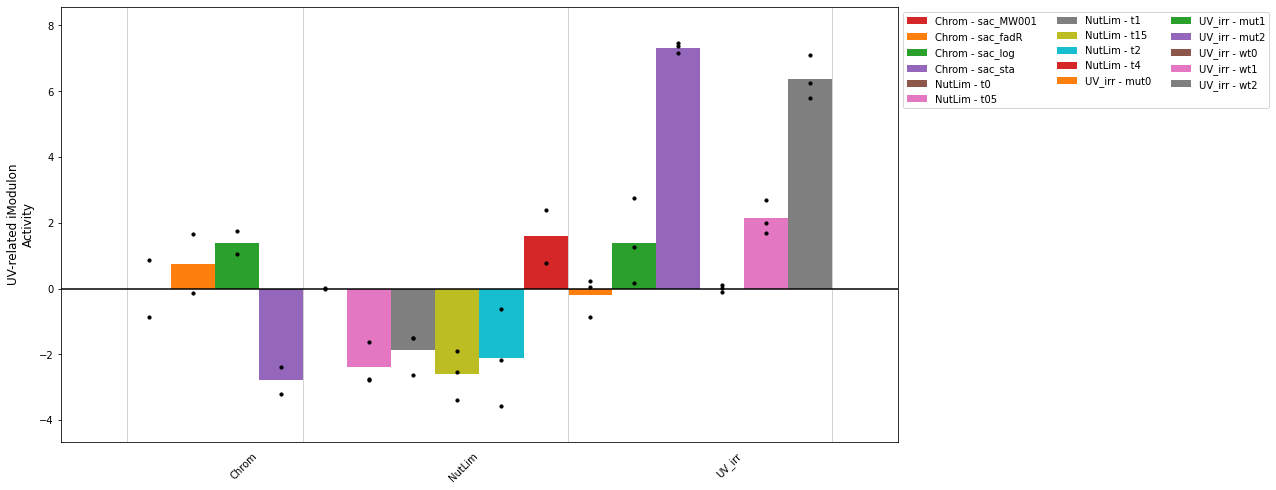

In [82]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_activities(ica_data, 'UV-related', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

## iModulon 33: Uncharacterized iModulon 2

<AxesSubplot:xlabel='Gene Start', ylabel='unchar-2 Gene Weight'>

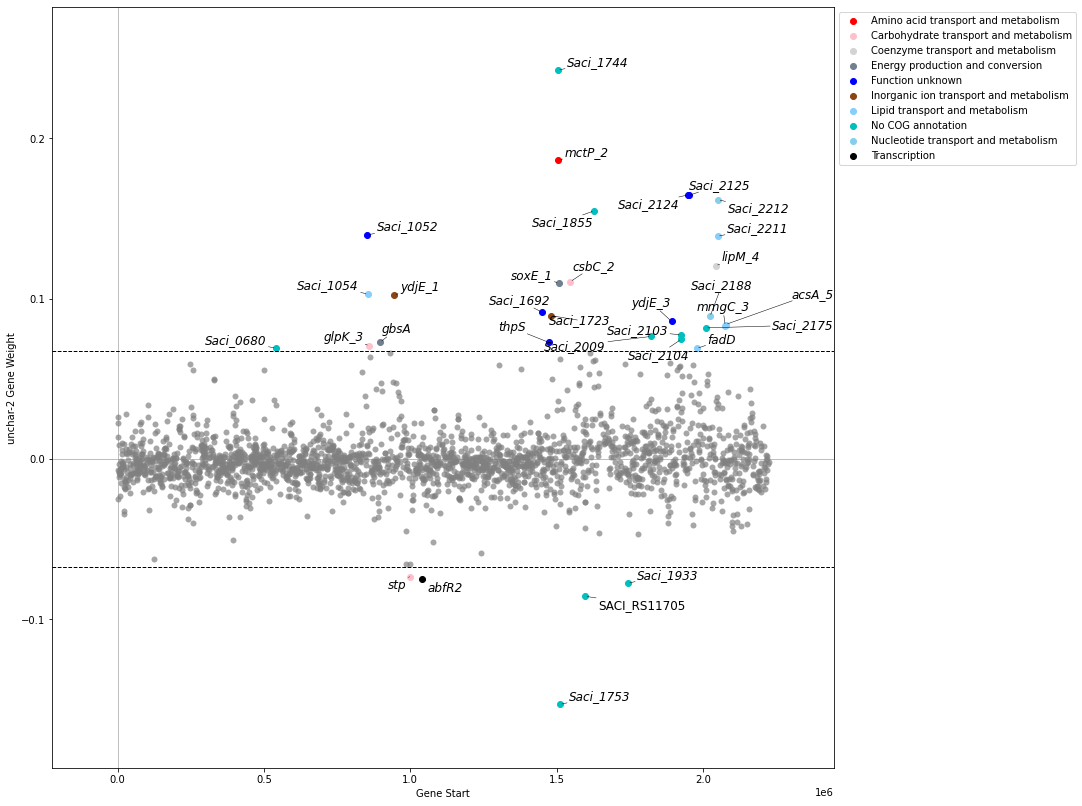

In [83]:
# iModulon decomposition (total) explains ~75% of the variance of the data
# This iModulon, by itself, explains ~12% of the variance in the data,
# by far the highest of all the iModulons.
# And it is mostly full of uncharacterized genes.

fig, ax = plt.subplots(figsize=(14, 14))

plot_gene_weights(ica_data, 'unchar-2', show_labels=True, ax=ax)

<AxesSubplot:xlabel='unchar-2'>

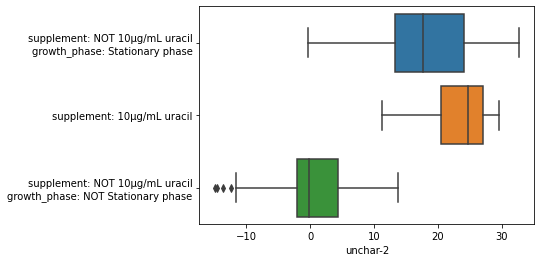

In [84]:
# The only project with a supplement of 10 ug/mL uracil is the NutLim project
# This boxplot suggest some sort of relationship between log/stat phase,
# and in nutrient rich vs nutrient poor conditions

metadata_boxplot(ica_data, 'unchar-2', n_boxes=3)

## iModulon 34: Replication/Cell-Division iModulon

Contains:
* segA
* segB
* cdc6-1
* cdvA
* cdvB
* cdvC
* cdvB1
* cdvB2
* __Many uncharacterized genes__

<AxesSubplot:xlabel='Gene Start', ylabel='Replication Gene Weight'>

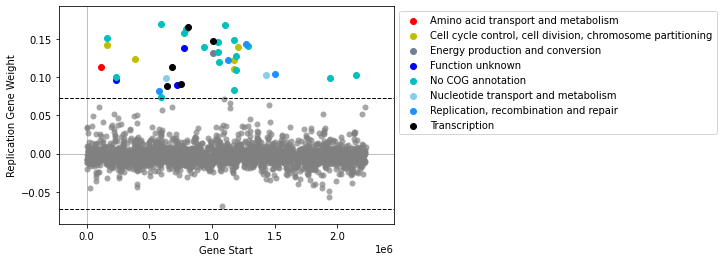

In [85]:
# iModulon contains too many genes to be displayed in this plot

plot_gene_weights(ica_data, 'Replication')

<AxesSubplot:xlabel='Replication'>

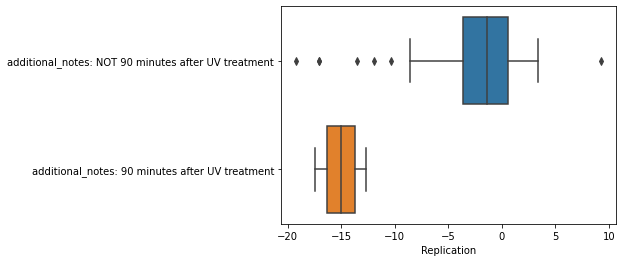

In [86]:
# Metadata boxplots shows this iModulon is heavily down regulated 90 min after UV exposure
metadata_boxplot(ica_data, 'Replication', n_boxes=2)

<AxesSubplot:ylabel='Replication iModulon\nActivity'>

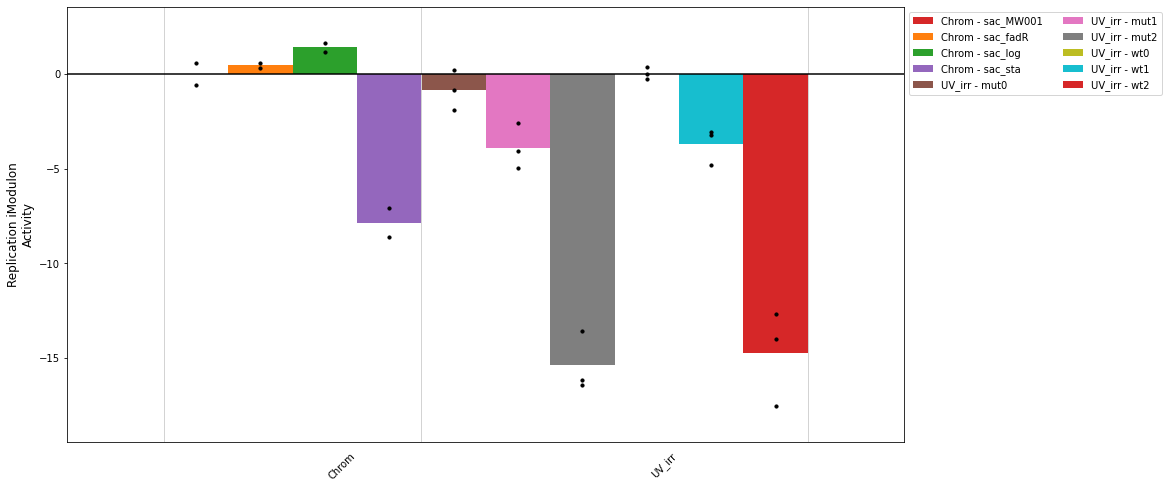

In [87]:
# As expected, this iModulon is downregulated in stationary phase,
# and after UV exposure (tfb3 independent)

fig, ax = plt.subplots(figsize=(15, 8))

plot_activities(ica_data, 'Replication', projects=['Chrom','UV_irr'], highlight=['Chrom','UV_irr'], ax=ax)

## iModulon 35: Translation-related/RpoN iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='translation-related Gene Weight'>

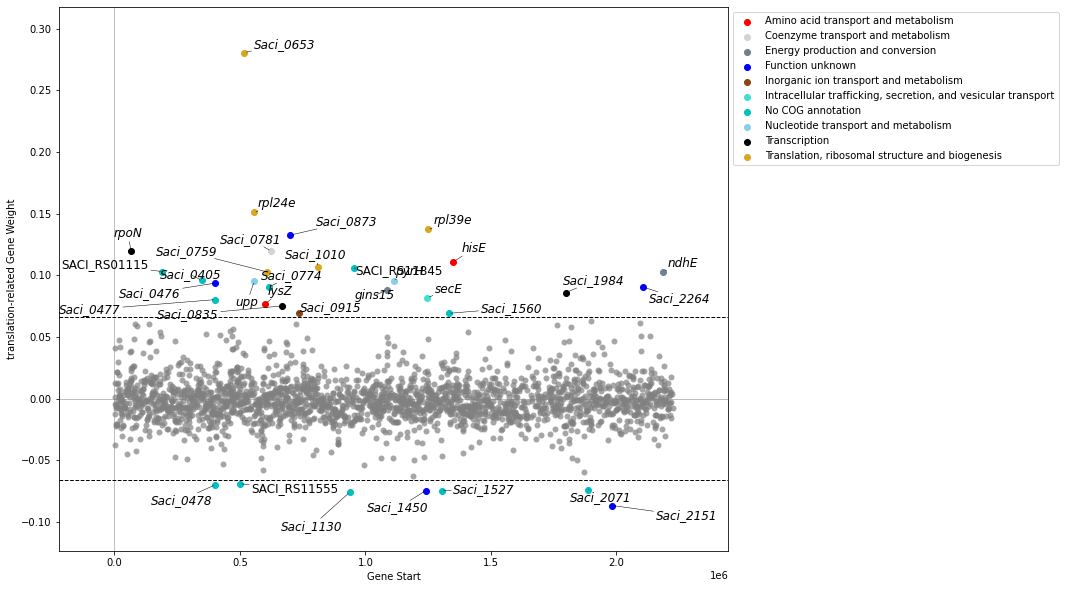

In [88]:
fig, ax = plt.subplots(figsize=(12, 10))

plot_gene_weights(ica_data, 'translation-related', show_labels=True, ax=ax)

<AxesSubplot:xlabel='translation-related'>

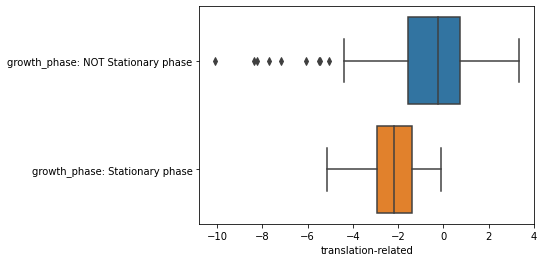

In [89]:
metadata_boxplot(ica_data, 'translation-related', n_boxes=2)

<AxesSubplot:ylabel='translation-related iModulon\nActivity'>

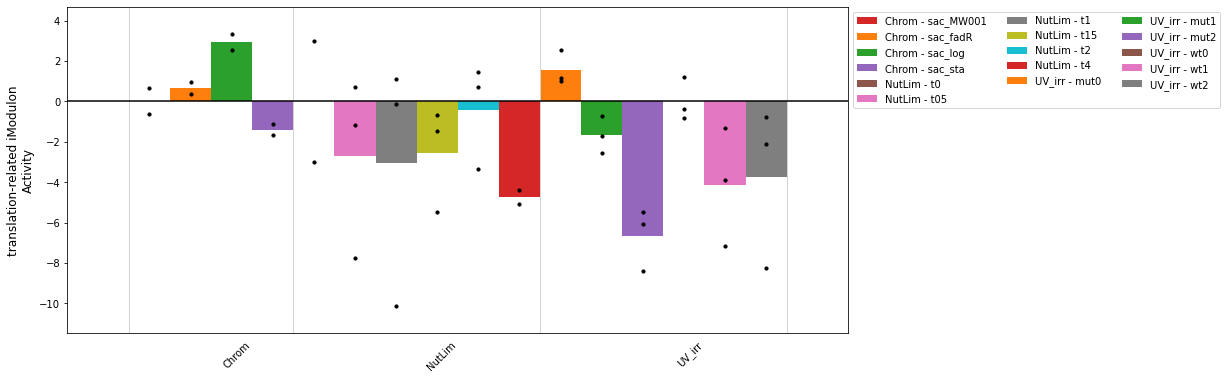

In [90]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'translation-related', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

## iModulon 36: Quinolinate / NAD(+) biosynthesis iModulon

- Putative Nicotine biosynthesis iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='Quinolinate Gene Weight'>

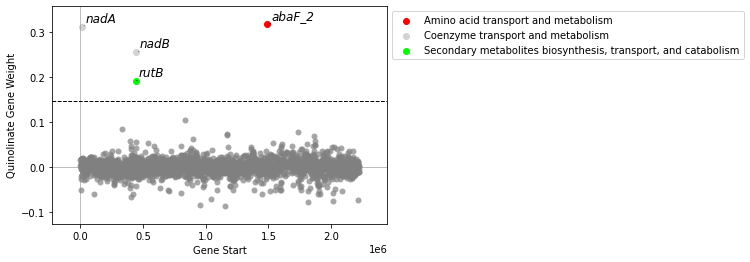

In [91]:
plot_gene_weights(ica_data, 'Quinolinate')

<AxesSubplot:xlabel='Quinolinate'>

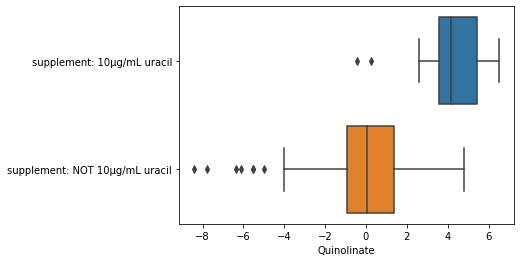

In [92]:
# Higher activity in NutLim conditions
metadata_boxplot(ica_data, 'Quinolinate', n_boxes=2)

<AxesSubplot:ylabel='Quinolinate iModulon\nActivity'>

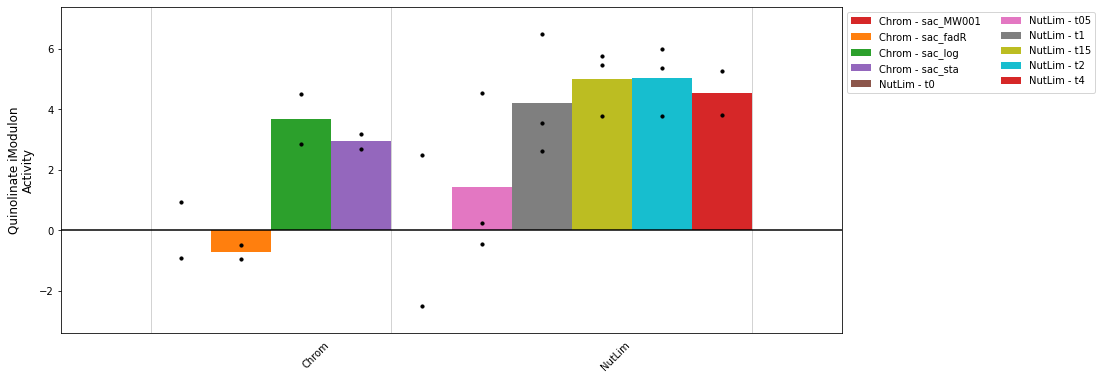

In [93]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Quinolinate', projects=['Chrom', 'NutLim'], highlight=['Chrom', 'NutLim'], ax=ax)

## iModulon 37: Aromatic Compound degradation iModulon (Possibly  Napthalene degradation)

* Contains Saci_2137, a known gene regulated by Saci_2136 (barR)
* Potentially regulated by BarR or BarR-like TF?

<AxesSubplot:xlabel='Gene Start', ylabel='aromatic-degradation Gene Weight'>

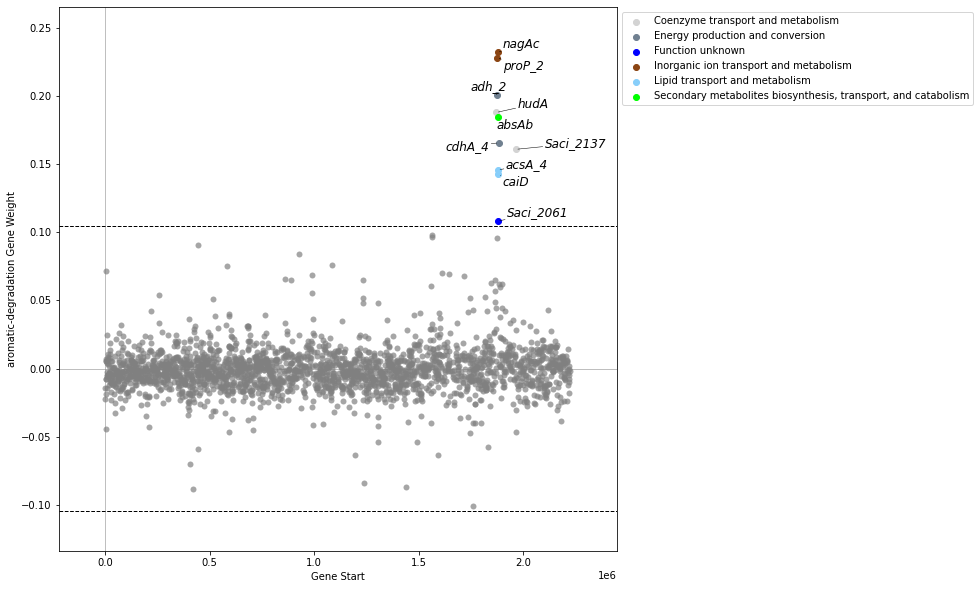

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_gene_weights(ica_data, 'aromatic-degradation', ax=ax)

<AxesSubplot:xlabel='aromatic-degradation'>

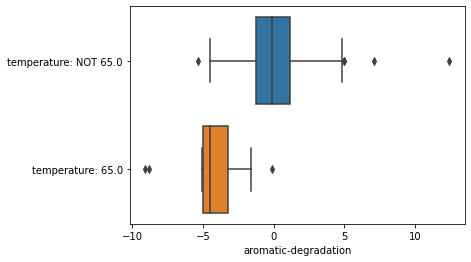

In [95]:
metadata_boxplot(ica_data, 'aromatic-degradation', n_boxes=2)

<AxesSubplot:ylabel='Quinolinate iModulon\nActivity'>

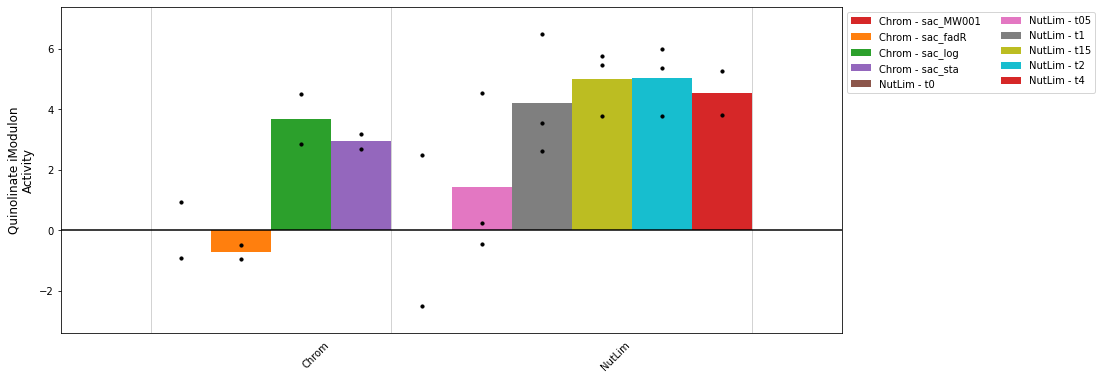

In [96]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Quinolinate', projects=['NutLim', 'Chrom'], highlight=['Chrom', 'NutLim'], ax=ax)

## iModulon 38: Ammonium Uptake iModulon [E coli Ortholog: NtrC+RpoN]

Probable Nitrogen Metabolism Involvement

<AxesSubplot:xlabel='Gene Start', ylabel='Ammonium-Uptake Gene Weight'>

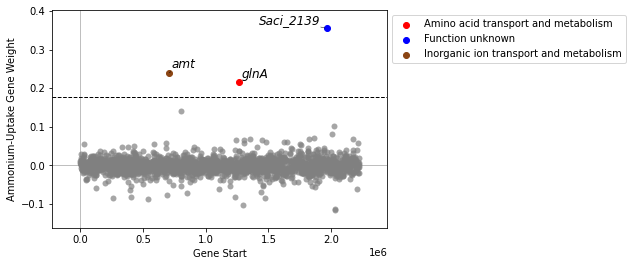

In [97]:
plot_gene_weights(ica_data, 'Ammonium-Uptake')

<AxesSubplot:ylabel='Ammonium-Uptake iModulon\nActivity'>

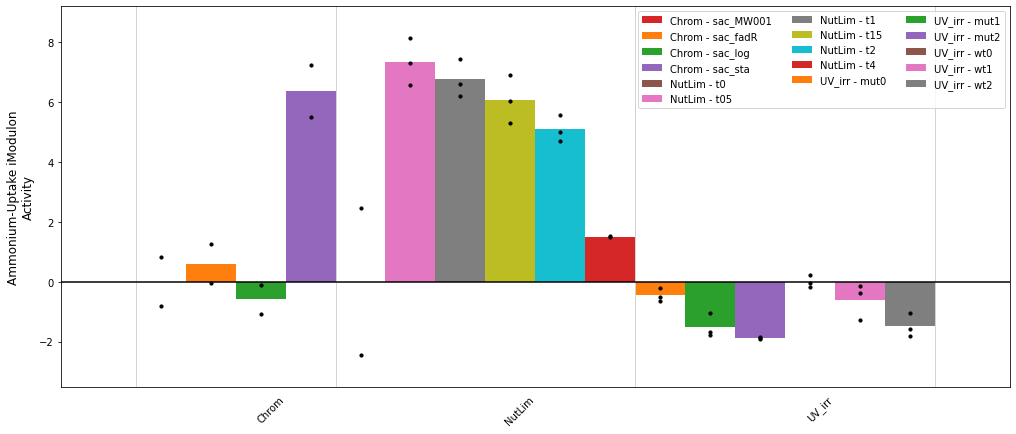

In [98]:
fig, ax = plt.subplots(figsize=(17, 7))

plot_activities(ica_data, 'Ammonium-Uptake', projects=['Chrom', 'NutLim', 'UV_irr'],
                highlight=['Chrom', 'NutLim', 'UV_irr'], ax=ax)

## iModulon 40: single_gene_4 (Uncharacterized iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='single_gene_4 Gene Weight'>

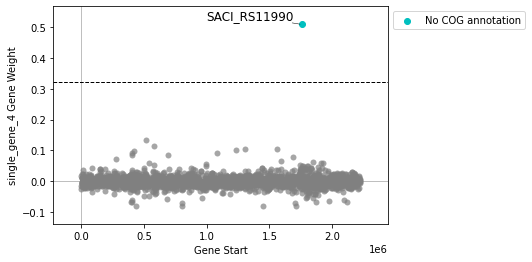

In [99]:
plot_gene_weights(ica_data, 'single_gene_4')

In [100]:
ica_data.view_imodulon('single_gene_4')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11990     0.508807  SACI_RS11990           NaN              NaN   

             synonyms      start        end strand  \
SACI_RS11990      NaN  1760019.0  1760123.0      +   

                                                  gene_product  \
SACI_RS11990  type II toxin-antitoxin system VapC family toxin   

             gene_product_prokka                COG        uniprot  \
SACI_RS11990                 NaN  No COG annotation  UPI0011BDD67A   

                   refseq regulator  
SACI_RS11990  NC_007181.1       NaN

## iModulon 41: Thiamin (Vit B1) iModulon

Potentially Heavy-Metal related

<AxesSubplot:xlabel='Gene Start', ylabel='Thiamin Gene Weight'>

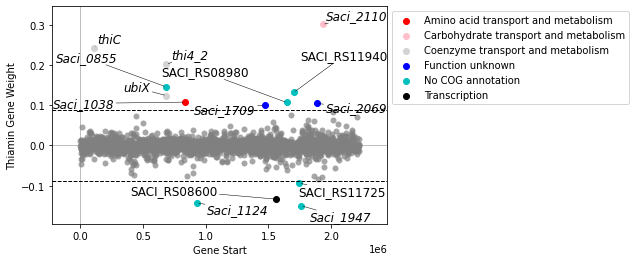

In [101]:
plot_gene_weights(ica_data, 'Thiamin')

<AxesSubplot:xlabel='Thiamin'>

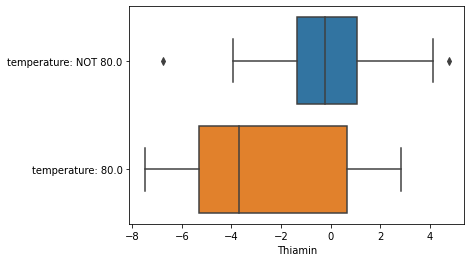

In [102]:
metadata_boxplot(ica_data, 'Thiamin', n_boxes=2)

<AxesSubplot:ylabel='Thiamin iModulon\nActivity'>

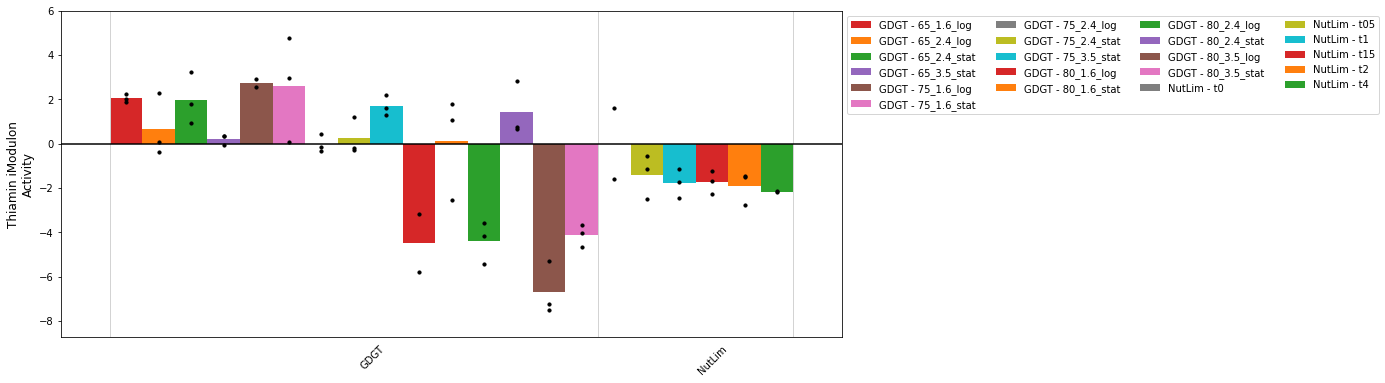

In [103]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Thiamin', projects=['GDGT', 'NutLim'], highlight=['GDGT', 'NutLim'], ax=ax)

## iModulon 42: Uncharacterized iModulon 3

* Possible batch effect / technical noise iModulon

<AxesSubplot:xlabel='Gene Start', ylabel='unchar-3 Gene Weight'>

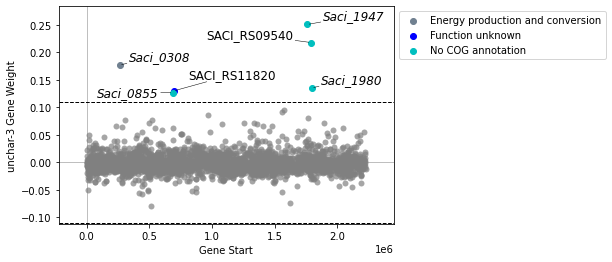

In [104]:
plot_gene_weights(ica_data, 'unchar-3')

<AxesSubplot:xlabel='unchar-3'>

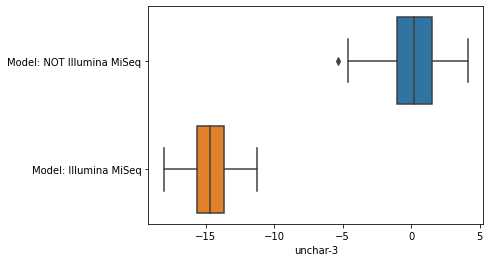

In [105]:
metadata_boxplot(ica_data, 'unchar-3', n_boxes=2)

## iModulon 43: single_gene_5 (Uncharacterized iModulon)

<AxesSubplot:xlabel='Gene Start', ylabel='single_gene_5 Gene Weight'>

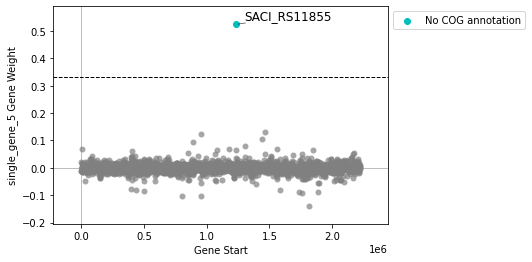

In [106]:
plot_gene_weights(ica_data, 'single_gene_5')

In [107]:
ica_data.view_imodulon('single_gene_5')

gene_weight     gene_name old_locus_tag prokka_locus_tag  \
SACI_RS11855     0.523488  SACI_RS11855           NaN              NaN   

             synonyms      start        end strand        gene_product  \
SACI_RS11855      NaN  1231584.0  1231667.0      +  putative integrase   

             gene_product_prokka                COG        uniprot  \
SACI_RS11855                 NaN  No COG annotation  UPI0011BFB8E2   

                   refseq regulator  
SACI_RS11855  NC_007181.1       NaN

## iModulon 44: Glycine/Serine iModulon

- Contains 3-phosphoglycerate dehydrogenase, the first committed step to making L-serine from 3-phosphoglycerate
- Contains serine-glyoxylate aminotransferase, which take L-serine and degrades it to produce glycine and 3-hydroxypyruvate
- May have antagonistic relationship to Thiamin iModulon


Additional References:

- https://www.nature.com/articles/s41467-019-11129-5.pdf

<AxesSubplot:xlabel='Gene Start', ylabel='Gly-Ser-Thr Gene Weight'>

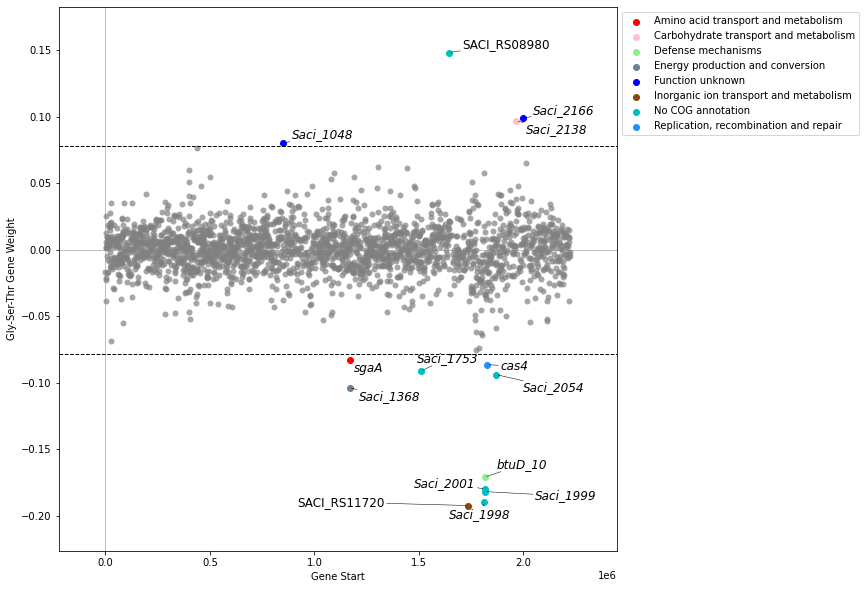

In [108]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_gene_weights(ica_data, 'Gly-Ser-Thr', ax=ax)

<AxesSubplot:xlabel='Gly-Ser-Thr'>

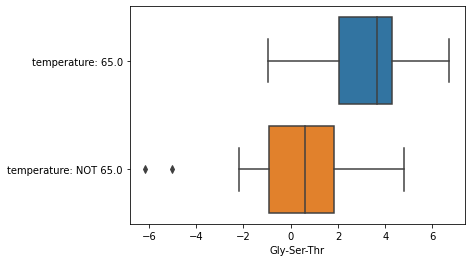

In [109]:
metadata_boxplot(ica_data, 'Gly-Ser-Thr', n_boxes=2)

<AxesSubplot:ylabel='Gly-Ser-Thr iModulon\nActivity'>

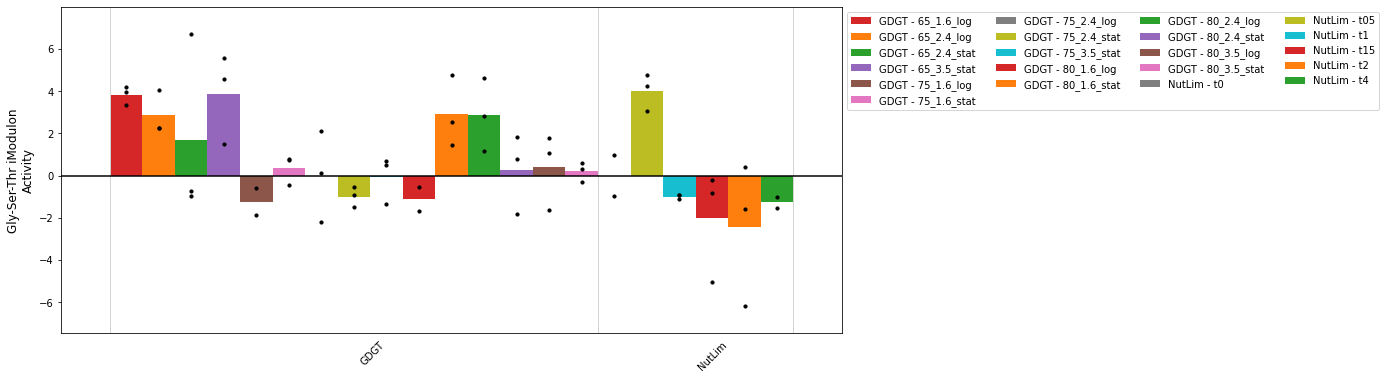

In [110]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'Gly-Ser-Thr', projects=['GDGT', 'NutLim'], highlight=['GDGT', 'NutLim'], ax=ax)

---

In [112]:
folder = '/Users/siddharth/Documents/Projects/S_acidocaldarius/iModulon_Enriched_Genes/'

for imod in ica_data.imodulon_names:
    
    file = folder + str(imod) + '.csv'
    ica_data.view_imodulon(imod).to_csv(file)